# Kółko - Olimpiada AI
## Wprowadzenie do Klasycznych Algorytmów Uczenia Maszynowego

---

### Zawartość - spis treści
1. **K-Nearest Neighbors (KNN)** - Wizualizacja granic decyzji
2. **Drzewa Decyzyjne** - Znaczenie cech
3. **Lasy Losowe** - przykład Ensemble Learning
4. **SVM** - Patrzenie z innej perspektywy na dane
5. **Regresja Liniowa** - Najprostszy algorytm ML
6. **Grid Search** - Dostrajanie hiperparametrów (+ ćwiczenia)

---


__O mnie__: Mateusz, jestem na doktoracie na UJ. Zajmuję się efektywniejszym podejściem do trenowania sieci, szczególnie w początkowych fazach trenowania.

__Kontakt__: mateusz.pyla@doctoral.uj.edu.pl

**Co 10 minut strefa dyskusji: pytajcie śmiało!**

__Dziś mamy__ 22.11.2025, materiały zostały przygotowane przeze mnie operając się na open-source GitHubowych repo i blogach; ze szczególnymi podziękowaniami do autorów linków wyminionych na koniec notebooka.

---

# 0. Wprowadzenie

Coraz ciężej motywować wstęp do tradycyjnych statystycznych modeli w kotekście uczenia maszynowego. Czy to już koniec klasycznego ML?

## Wysokopoziomowo

- Koncepty się nie zmieniają, problemy są wciąż te same
- Industry wciąż używa (wytłumaczalność, skalowalność, problem z danymi)
- Ucz się na przeszłości: SVM rozkwit miało po 30 latach od koncepcji...
- Dla Was: jak myśleć o typach problemów

## Nie zawsze te sieci neuronowe...
- mało danych
- dane uporządkowane
- lepsze zrozumienie zachowania
- szybsza inferencja

In [ ]:
# Importowanie wymaganych bibliotek - z części metod nie niekorzystamy, ale mogą być przydatne ogólnie 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.datasets import load_wine, load_diabetes, load_iris, load_digits
from sklearn.datasets import make_circles, make_blobs, make_moons, make_regression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso

np.random.seed(8)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ Wszystkie biblioteki załadowane, jazda!')

✓ Wszystkie biblioteki załadowane, jazda!


# 1. K-NEAREST NEIGHBORS (KNN)

## Teoria
KNN to algorytm oparty na instancjach (pojedynczych danych) - podejmuje decyzje na podstawie K najbliższych sąsiadów. Jest to przykład nieparametrycznego podejścia.

### Jak działa:
1. Dla nowego punktu oblicz odległość (szeroko pojęta odległość!) do WSZYSTKICH punktów treningowych
2. Znajdź K najbliższych sąsiadów
3. Klasyfikacja: głosowanie większościowe
4. Regresja: średnia wartość

### Hyperparametry:
1. K, jak duże otoczenie jest istotne
2. Norma, jak mierzymy odległość

_Ważne: Zawsze normalizuj cechy dla KNN!_
_Albo używaj innej metryki_

## Nabierzmy intuicji:

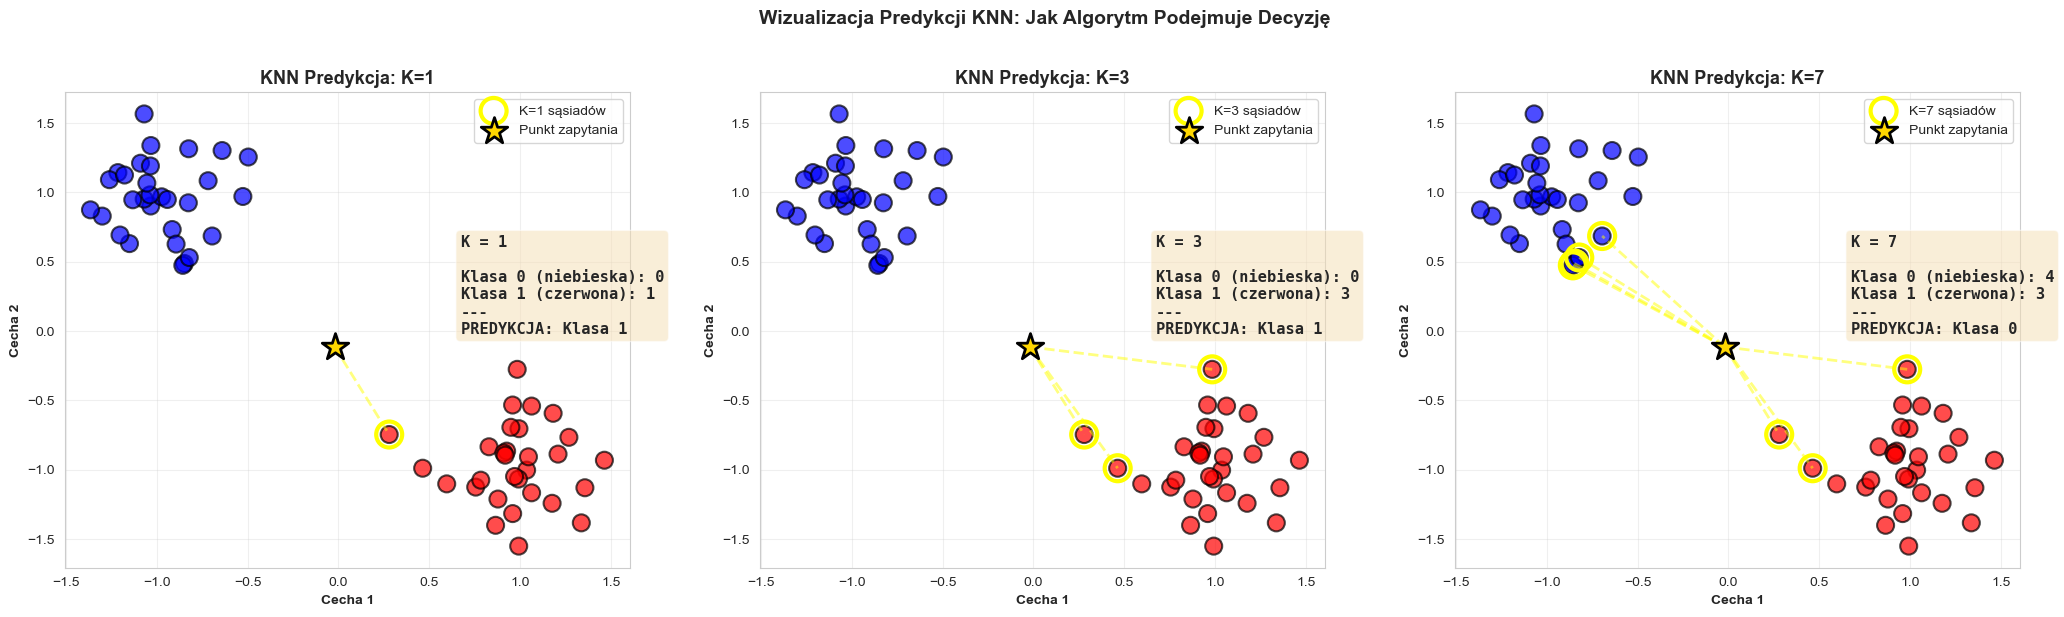


 Co się dzieje?
1. Punkt zapytania (*) - nowy punkt, którą klasę ma przybliżyć
2. Żółte koła - K najbliższych sąsiadów
3. Przerywane linie - odległości od nowego punktu
4. Głosowanie - większość sąsiadów decyduje o klasie


In [30]:
X_demo, y_demo = make_blobs(n_samples=60, n_features=2, centers=2,
                             cluster_std=1.0, random_state=42)

# Normalizacja
scaler_demo = StandardScaler()
X_demo_scaled = scaler_demo.fit_transform(X_demo)

# Definiowanie punktu zapytania
query_point = np.array([[0.88, 5.0]])
query_point_scaled = scaler_demo.transform(query_point)

# Wizualizacja dla K=1 i K=3 (i K=7)
ks = [1, 3, 7]
fig, axes = plt.subplots(1, len(ks), figsize=(21, 6))

for idx, k_val in enumerate(ks):
    ax = axes[idx]
    
    # Obliczenie odległości
    distances = np.linalg.norm(X_demo_scaled - query_point_scaled, axis=1)
    nearest_indices = np.argsort(distances)[:k_val]
    
    # Rysowanie wszystkich punktów
    scatter = ax.scatter(X_demo_scaled[:, 0], X_demo_scaled[:, 1], 
                             c=y_demo, cmap=plt.cm.bwr, s=150, 
                             edgecolors='k', linewidth=1.5, alpha=0.7)
    
    # Wyróżnienie K najbliższych sąsiadów
    ax.scatter(X_demo_scaled[nearest_indices, 0], X_demo_scaled[nearest_indices, 1],
              s=350, facecolors='none', edgecolors='yellow', linewidth=3, label=f'K={k_val} sąsiadów')
    
    # Punkt zapytania
    ax.scatter(query_point_scaled[:, 0], query_point_scaled[:, 1],
              s=400, marker='*', c='gold', edgecolors='black', linewidth=2, 
              label='Punkt zapytania', zorder=5)
    
    # Połączenia do sąsiadów
    for neighbor_idx in nearest_indices:
        ax.plot([query_point_scaled[0, 0], X_demo_scaled[neighbor_idx, 0]],
               [query_point_scaled[0, 1], X_demo_scaled[neighbor_idx, 1]],
               'yellow', linewidth=2, alpha=0.5, linestyle='--')
    
    # Statystyka głosowania
    neighbor_classes = y_demo[nearest_indices]
    predicted_class = np.bincount(neighbor_classes).argmax()
    
    # Tekst wyjaśniający
    class_0_count = np.sum(neighbor_classes == 0)
    class_1_count = np.sum(neighbor_classes == 1)
    
    textstr = f'K = {k_val}\n\n'
    textstr += f'Klasa 0 (niebieska): {class_0_count}\n'
    textstr += f'Klasa 1 (czerwona): {class_1_count}\n'
    textstr += f'---\n'
    textstr += f'PREDYKCJA: Klasa {predicted_class}'
    
    ax.text(0.7, 0.7, textstr, transform=ax.transAxes,
           fontsize=11, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           family='monospace', fontweight='bold')
    
    ax.set_xlabel('Cecha 1', fontweight='bold')
    ax.set_ylabel('Cecha 2', fontweight='bold')
    ax.set_title(f'KNN Predykcja: K={k_val}', fontweight='bold', fontsize=13)
    ax.legend(fontsize=10) # 'lower right'
    ax.grid(True, alpha=0.3)

plt.suptitle('Wizualizacja Predykcji KNN: Jak Algorytm Podejmuje Decyzję',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n Co się dzieje?')
print('1. Punkt zapytania (*) - nowy punkt, którą klasę ma przybliżyć')
print('2. Żółte koła - K najbliższych sąsiadów')
print('3. Przerywane linie - odległości od nowego punktu')
print('4. Głosowanie - większość sąsiadów decyduje o klasie')

## Okay, jakie K ma znaczenie?

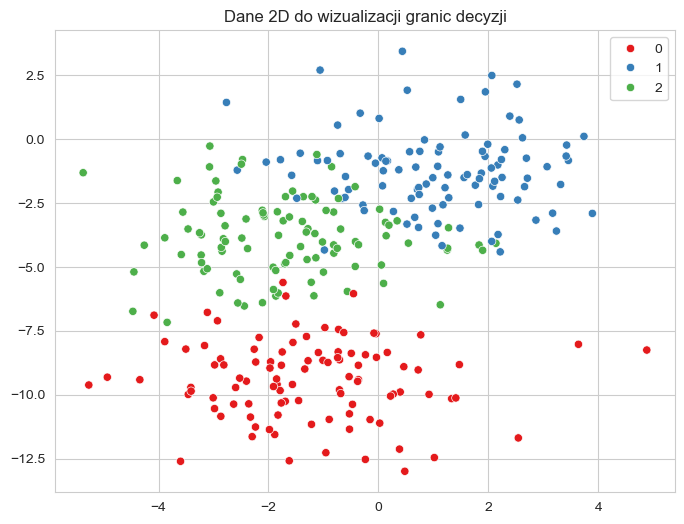

In [3]:
# Generowanie danych 2D dla wizualizacji granic decyzji
X_2d, y_2d = make_blobs(n_samples=300, n_features=2, centers=3,
                        cluster_std=1.5, random_state=2)

# Jak wyglądają dane?
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_2d, palette='Set1')
plt.title('Dane 2D do wizualizacji granic decyzji')
plt.show()

Pomysł na przedstawienie jak działa nasz KNN: dla każdego punktu $(x_0, y_0)$ na płaszczyźnie zrób predykcje. Póki co wizualnie sprawdzimy jak sobie model radzi.

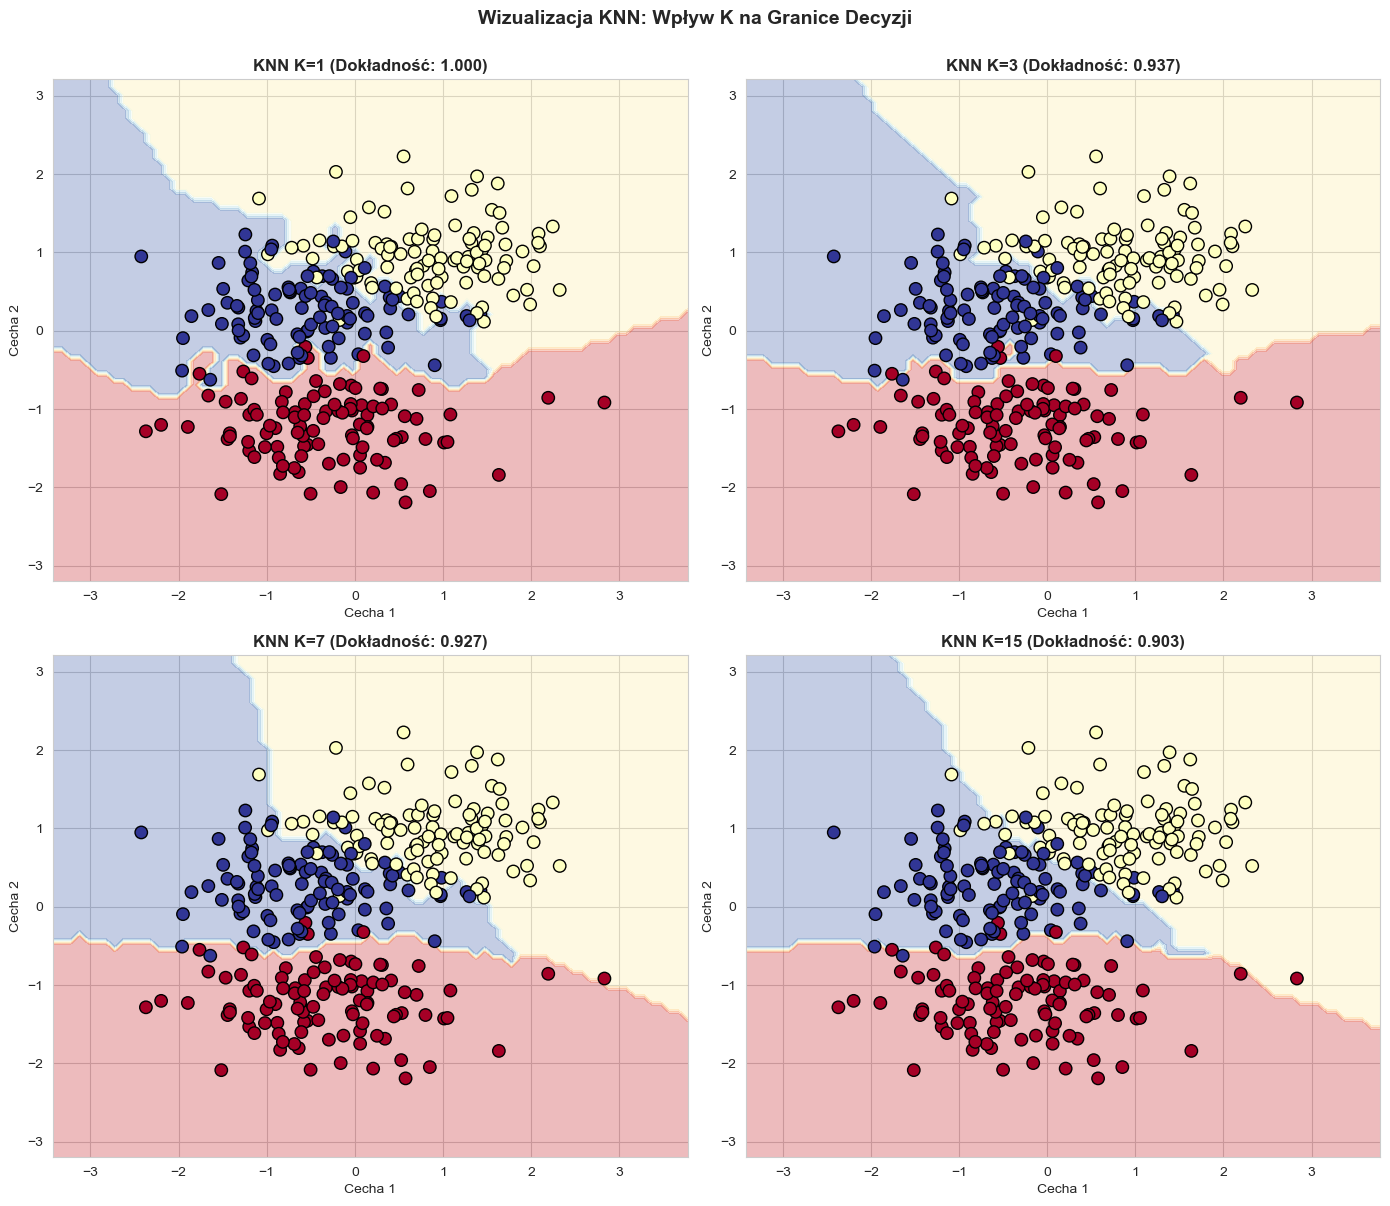

Obserwacje:
- K=1: Bardzo elastyczne (przeuczenie)
- K=7,15: Bardziej gładkie granice
Czy możemy w takim razie zwiększać K w nieskończoność?

Odpowiedź:
Nie! Zbyt duże K prowadzi do nadmiernego uogólnienia, gdzie model ignoruje lokalne wzorce.
- K=255: Dokładność spada do 0.750, model staje się zbyt ogólny.


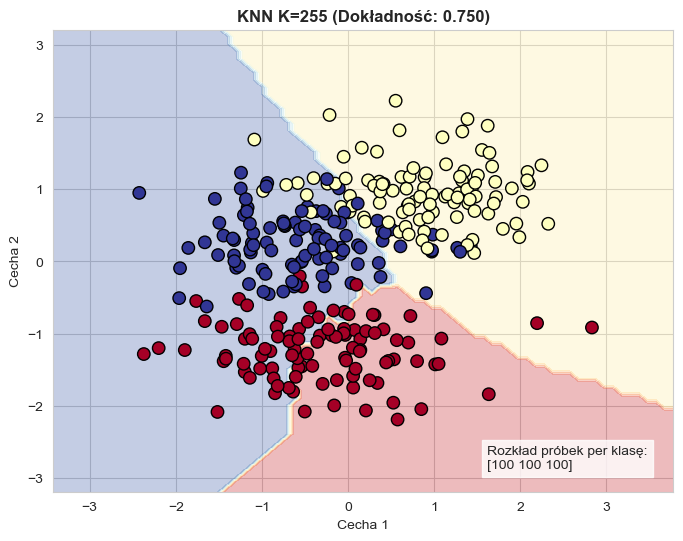

In [4]:
# Normalizacja
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

# Wizualizacja wpływu K na granice decyzji
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
k_values = [1, 3, 7, 15]

for idx, k_val in enumerate(k_values):
    ax = axes[idx // 2, idx % 2]
    
    # Trening KNN
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(X_2d_scaled, y_2d)
    
    # Tworzenie siatki
    h = 0.1
    x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
    y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Przewidywanie
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Rysowanie
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y_2d,
              cmap=plt.cm.RdYlBu, edgecolors='k', s=80)
    
    acc = knn.score(X_2d_scaled, y_2d)
    ax.set_title(f'KNN K={k_val} (Dokładność: {acc:.3f})', fontweight='bold')
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')

plt.suptitle('Wizualizacja KNN: Wpływ K na Granice Decyzji',
             fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

print('Obserwacje:')
print('- K=1: Bardzo elastyczne (przeuczenie)')
print('- K=7,15: Bardziej gładkie granice')

print("Czy możemy w takim razie zwiększać K w nieskończoność?")
print('\nOdpowiedź:')
print('Nie! Zbyt duże K prowadzi do nadmiernego uogólnienia, gdzie model ignoruje lokalne wzorce.')

too_large_value = int(0.85*len(X_2d))  # K równe 85% liczby próbek
knn_too_large = KNeighborsClassifier(n_neighbors=too_large_value)
knn_too_large.fit(X_2d_scaled, y_2d)
acc_too_large = knn_too_large.score(X_2d_scaled, y_2d)
print(f'- K={too_large_value}: Dokładność spada do {acc_too_large:.3f}, model staje się zbyt ogólny.')
# Wizualizacja:
fig, ax = plt.subplots(figsize=(8, 6))
# Tworzenie siatki
h = 0.1
x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Przewidywanie
Z = knn_too_large.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Rysowanie
ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y_2d,
          cmap=plt.cm.RdYlBu, edgecolors='k', s=80)
ax.set_title(f'KNN K={too_large_value} (Dokładność: {acc_too_large:.3f})', fontweight='bold')
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.text(0.7, 0.05, f'Rozkład próbek per klasę:\n{np.bincount(y_2d)}',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

## No więc jak wybrać ten parametr K?

Wybór optymalnej wartości K nie jest zawsze oczywisty! Zobaczmy różne scenariusze.

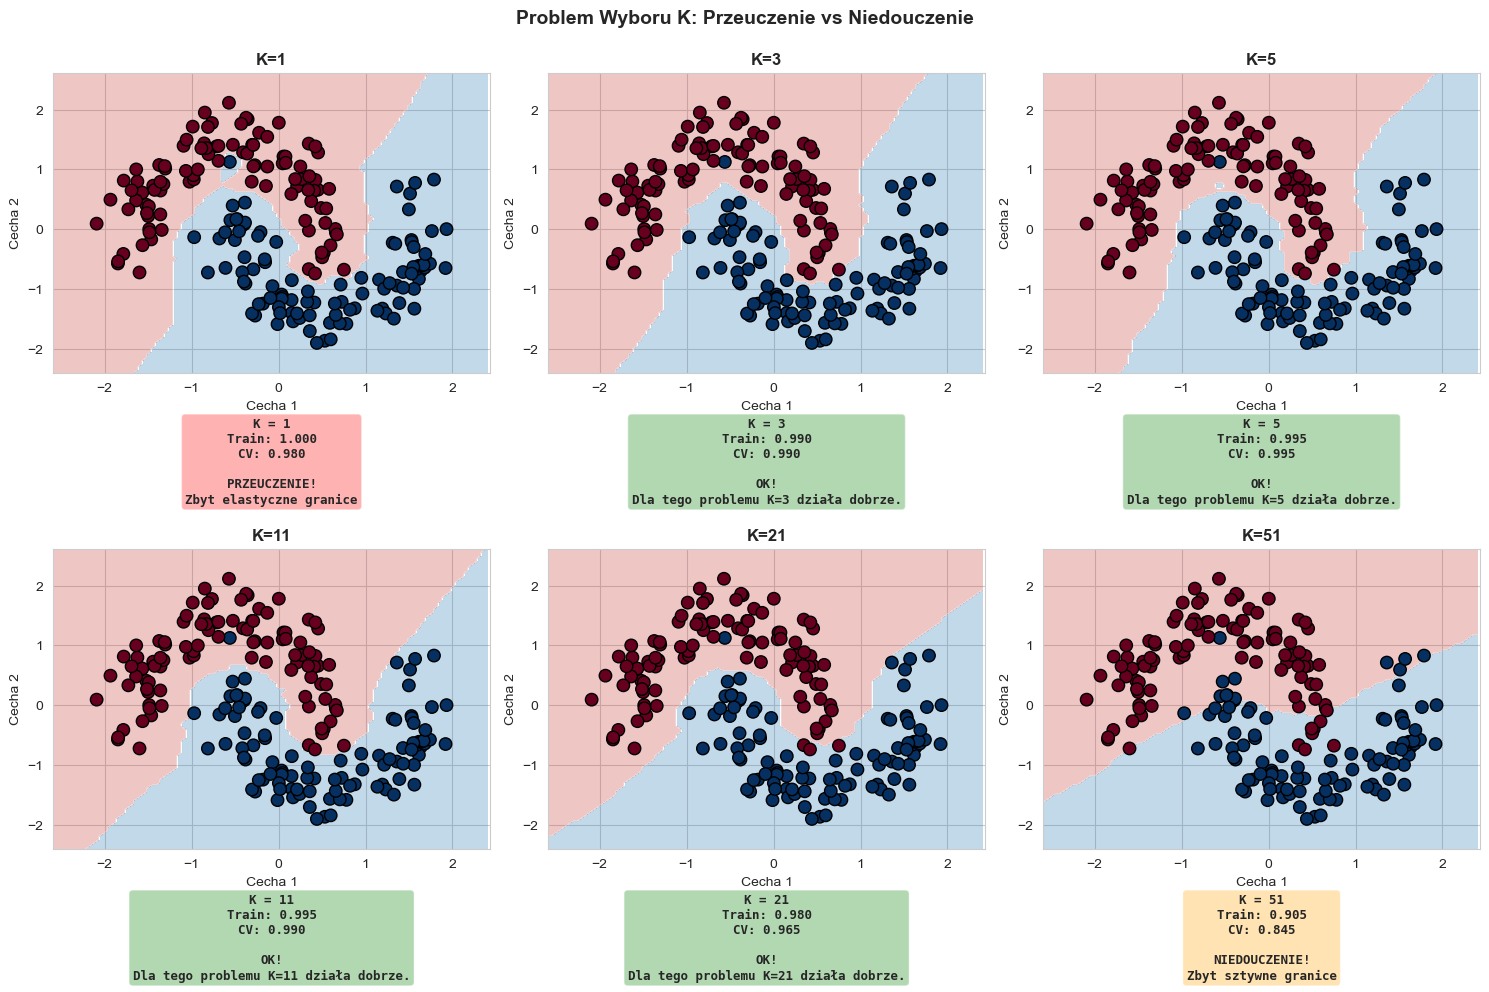


 POTENCJALNE PROBLEMY PRZY WYBORZE K:

1. K=1 (PRZEUCZENIE):
   - Model pamiętał każdy punkt treningowy
   - Bardzo elastyczne, skomplikowane granice
   - Słaba generalizacja na nowych danych

2. K bardzo duże (NIEDOUCZENIE):
   - Zbyt wiele głosów = zbyt uproszczona decyzja
   - Sztywne granice, model ignuje lokalne struktury
   - Może niedopasować się do rzeczywistego rozkładu

3. Brak oczywistego "najlepszego" K:
   - Różne K mogą być dobre dla różnych metryk dla różnych danych
   - Wymagana cross-validacja lub dodatkowa ocena


In [ ]:
# Generowanie danych z różnymi scenariuszami
X_knn, y_knn = make_moons(n_samples=200, noise=0.15, random_state=42)
X_knn_scaled = StandardScaler().fit_transform(X_knn)

# Wizualizacja granic decyzji dla różnych K
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k_values = [1, 3, 5, 11, 21, 51]

for idx, k_val in enumerate(k_values):
    ax = axes[idx // 3, idx % 3]
    
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(X_knn_scaled, y_knn)
    
    # Siatka
    h = 0.05
    x_min, x_max = X_knn_scaled[:, 0].min() - 0.5, X_knn_scaled[:, 0].max() + 0.5
    y_min, y_max = X_knn_scaled[:, 1].min() - 0.5, X_knn_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu, levels=2)
    ax.scatter(X_knn_scaled[:, 0], X_knn_scaled[:, 1], c=y_knn,
              cmap=plt.cm.RdBu, edgecolors='k', s=80)
    
    train_acc = knn.score(X_knn_scaled, y_knn)
    cv_scores = cross_val_score(knn, X_knn_scaled, y_knn, cv=5)
    
    # Wiadomość o problemach (uproszczenie)
    if k_val == 1:
        problem = 'PRZEUCZENIE!\nZbyt elastyczne granice'
        color = 'red'
    elif k_val == 51:
        problem = 'NIEDOUCZENIE!\nZbyt sztywne granice'
        color = 'orange'
    else:
        problem = f'OK!\nDla tego problemu K={k_val} działa dobrze.'
        color = 'green'
    
    textstr = f'K = {k_val}\nTrain: {train_acc:.3f}\nCV: {cv_scores.mean():.3f}\n\n{problem}'
    ax.text(0.5, -0.15, textstr, transform=ax.transAxes,
           fontsize=9, ha='center', va='top',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3),
           family='monospace', fontweight='bold')
    
    ax.set_title(f'K={k_val}', fontweight='bold')
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

plt.suptitle('Problem Wyboru K: Przeuczenie vs Niedouczenie',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('\n POTENCJALNE PROBLEMY PRZY WYBORZE K:')
print('\n1. K=1 (PRZEUCZENIE):')
print('   - Model pamiętał każdy punkt treningowy')
print('   - Bardzo elastyczne, skomplikowane granice')
print('   - Słaba generalizacja na nowych danych')
print('\n2. K bardzo duże (NIEDOUCZENIE):')
print('   - Zbyt wiele głosów = zbyt uproszczona decyzja')
print('   - Sztywne granice, model ignuje lokalne struktury')
print('   - Może niedopasować się do rzeczywistego rozkładu')
print('\n3. Brak oczywistego "najlepszego" K:')
print('   - Różne K mogą być dobre dla różnych metryk dla różnych danych')
print('   - Wymagana cross-validacja lub dodatkowa ocena')


## Ćwiczenia

### Cwiczenie 1.1: Spróbuj zaimplementować klasyfikator KNN samemu.
---------------------------------------------------
Zaimplementuj prosty regresor KNN bez użycia scikit-learn.  
Twoja klasa powinna mieć:  
- fit(X, y): zapisz dane treningowe  
- predict(X): przewiduj wartości (ciągłe - problem regresji) dla nowych danych  
- Obsługa metryk odległości: euklidesowa, manhattan, minkowski (p)

### Ćwiczenie 1.2: Dla problemu regresji, znajdź optymalny zestaw hiperparametrów (np. optymalne K)
----------------------------------------------
Korzystając ze zbioru danych Diabetes (regresja):
1. Podziel dane na zbiory treningowy/testowy (70/30)
2. Przetestuj wartości K od 1 do 50
3. Narysuj wykres RMSE oraz R² w zależności od wartości K
4. Znajdź optymalne K (najniższe RMSE / najwyższe R²)
5. Wyjaśnij, dlaczego bardzo małe lub bardzo duże wartości K mogą być problematyczne

### Ćwiczenie 1.3: Porównaj wpływ wybrania metryki.
----------------------------------------
Porównaj wydajność regresji KNN dla różnych metryk odległości:
- Odległość euklidesowa (domyślna)
- Odległość Manhattan
- Odległość Minkowskiego (p=3)

Na zbiorze Diabetes co działa najlepiej? I dlaczego?

---

### Rozwiązania 
(hej, zachęcam do zrobienia samemu!)

Best K by RMSE: 28, RMSE=55.228
Best K by R²: 28, R²=0.402


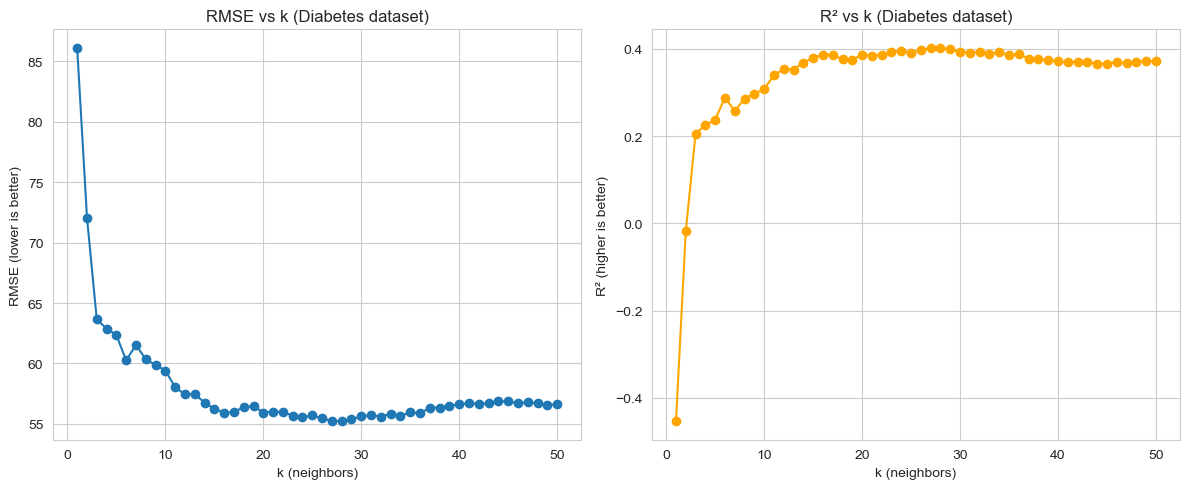

Explanation:
- Very small k (e.g., k=1): low bias, high variance; model may overfit noise -> high test RMSE.
- Very large k (e.g., k ~ n_train): high bias, low variance; model becomes too smooth -> underfits and larger RMSE.
- The optimal k balances this bias-variance tradeoff (see plotted curves).
Metric: euclidean -> RMSE: 55.228, R²: 0.402
Metric: manhattan -> RMSE: 56.364, R²: 0.377
Metric: minkowski(p=3) -> RMSE: 55.418, R²: 0.398


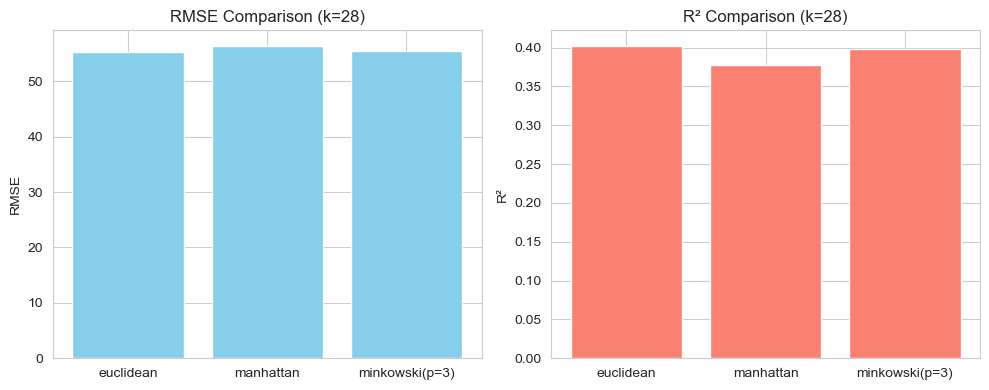

Interpretation:
- Different datasets and feature scales favor different metrics.
- Euclidean is common for continuous features; Manhattan can be more robust if features have outliers.
- Minkowski with p=3 is between Euclidean (p=2) and higher-order distance; doesn't often beat Euclidean on standardized numeric data.
- If features are not scaled equally, distance metrics can be dominated by large-scale features (scale data prior to KNN).


In [ ]:
### Rozwiązania

# 1.1
class SimpleKNNRegressor:
   def __init__(self, k=3, metric='euclidean', p=2):
      """
      k: liczba sąsiadów
      metric: 'euclidean', 'manhattan', 'minkowski'
      p: Minkowski - parametr p miary Minikowskiego (używany gdy metric='minkowski')
      """
      self.k = int(k)
      self.metric = metric
      self.p = p
      self._X = None
      self._y = None

   def fit(self, X, y):
      X = np.asarray(X)
      y = np.asarray(y)
      if X.ndim == 1:
         X = X.reshape(-1, 1)
      self._X = X
      self._y = y
      return self

   def _pairwise_distances(self, X):
      """Oblicz macierz odległości między wierszami X a self._X."""
      X = np.asarray(X)
      if X.ndim == 1:
         X = X.reshape(-1, 1)
      # Broadcasting approach:
      if self.metric == 'euclidean':
         diff = X[:, np.newaxis, :] - self._X[np.newaxis, :, :]
         dists = np.sqrt(np.sum(diff ** 2, axis=2))
      elif self.metric == 'manhattan':
         diff = X[:, np.newaxis, :] - self._X[np.newaxis, :, :]
         dists = np.sum(np.abs(diff), axis=2)
      elif self.metric == 'minkowski':
         if self.p <= 0:
            raise ValueError("p musi być > 0 dla metryki Minkowskiego")
         diff = np.abs(X[:, np.newaxis, :] - self._X[np.newaxis, :, :]) ** self.p
         dists = np.sum(diff, axis=2) ** (1.0 / self.p)
      else:
         raise ValueError(f"Nieznana metryka: {self.metric}")
      return dists

   def predict(self, X):
      assert self._X is not None and self._y is not None, "Model nie był wczytany / 'uczony'."
      X = np.asarray(X)
      if X.ndim == 1:
         X = X.reshape(-1, 1)
      n_train = self._X.shape[0]
      k = min(self.k, n_train)
      if k < 1:
         raise ValueError("k musi być >= 1")
      dists = self._pairwise_distances(X)  # shape (n_test, n_train)
      knn_idx = np.argsort(dists, axis=1)[:, :k]
      # For regression, use simple average of neighbors' targets
      predictions = np.array([self._y[idx].mean() for idx in knn_idx])
      return predictions

# 1.2
# Load dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Train/test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.30, random_state=0
)

ks = range(1, 51)
rmse_vals = []
r2_vals = []

for k in ks:
   model = SimpleKNNRegressor(k=k, metric='euclidean')
   model.fit(X_train, y_train)
   preds = model.predict(X_test)
   rmse = np.sqrt(mean_squared_error(y_test, preds))
   r2 = r2_score(y_test, preds)
   rmse_vals.append(rmse)
   r2_vals.append(r2)

best_k_rmse = ks[int(np.argmin(rmse_vals))]
best_k_r2 = ks[int(np.argmax(r2_vals))]

print(f"Najlepsze K zgodnie z RMSE: {best_k_rmse}, RMSE={min(rmse_vals):.3f}")
print(f"Najlepsze K zgodnie z R²: {best_k_r2}, R²={max(r2_vals):.3f}")

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ks, rmse_vals, marker='o')
plt.xlabel('k (sąsiadów)')
plt.ylabel('RMSE (mniej lepsze)')
plt.title('RMSE vs k (Zbiór danych Diabetes)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, r2_vals, marker='o', color='orange')
plt.xlabel('k (sąsiadów)')
plt.ylabel('R² (większe lepsze)')
plt.title('R² vs k (Zbiór danych Diabetes)')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Wytłumaczenie:")
print("- Bardzo małe k (np. k=1): niskie uprzedzenie, wysoka wariancja; model może przeuczyć szum -> wysokie RMSE na teście.")
print("- Bardzo duże k (np. k ~ n_train): wysokie uprzedzenie, niska wariancja; model staje się zbyt gładki -> niedouczenie i większe RMSE.")
print("- Optymalne k balansuje ten kompromis bias-wariancja (patrz wykresy).")

# 1.3
metrics_to_try = [
   ("euclidean", None),
   ("manhattan", None),
   ("minkowski", 3), # z gwiazdką
]

results = []
k_for_comparison = best_k_rmse  # wybierz najlepsze K znalezione powyżej dla spójnego porównania

for metric_name, p in metrics_to_try:
   model = SimpleKNNRegressor(k=k_for_comparison, metric=metric_name if p is None else 'minkowski', p=(p if p is not None else 2))
   model.fit(X_train, y_train)
   preds = model.predict(X_test)
   rmse = np.sqrt(mean_squared_error(y_test, preds))
   r2 = r2_score(y_test, preds)
   results.append((metric_name if p is None else f"minkowski(p={p})", rmse, r2))
   print(f"Metryka: {metric_name if p is None else f'minkowski(p={p})'} -> RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Bar plot for RMSE comparison
labels = [r[0] for r in results]
rmse_vals_m = [r[1] for r in results]
r2_vals_m = [r[2] for r in results]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, rmse_vals_m, color='skyblue')
plt.ylabel('RMSE')
plt.title(f'Porównanie RMSE (k={k_for_comparison})')

plt.subplot(1, 2, 2)
plt.bar(labels, r2_vals_m, color='salmon')
plt.ylabel('R²')
plt.title(f'Porównanie R² (k={k_for_comparison})')

plt.tight_layout()
plt.show()

print("Interpretacja:")
print("- Różne zbiory danych i skale cech faworyzują różne metryki.")
print("- Metryka euklidesowa jest powszechna dla cech ciągłych; Manhattan może być bardziej odporna, jeśli cechy mają wartości odstające.")
print("- Minkowski z p=3 jest pomiędzy euklidesową (p=2) a metryką wyższego rzędu; rzadko przewyższa euklidesową na standaryzowanych danych numerycznych.")
print("- Jeśli cechy nie są skalowane równomiernie, metryki odległości mogą być zdominowane przez cechy o dużej skali (skaluj dane przed KNN).")

# 2. DRZEWA DECYZYJNE

## Teoria
Drzewo decyzyjne dzieli dane na podstawie testów cech, budując hierarchiczną strukturę.

### Jak działają?

Wyboraźmy sobie, że jesteśmy instytucją finansową i szukamy klientów, do których warto zadzwonić z nową ofertą.
Drzewo decyzyjne to model hierarchiczny, który rekurencyjnie dzieli dane:

```
                    [Wszyscy klienci]
                           |
                     Czy wiek > 30?
                    /            \
                  TAK            NIE
                  /                \
        [Dorośli (30+)]      [Młodzież (<30)]
              |                      |
        Czy dochód > 50k?    Czy ma ID studenta?
          /        \              /        \
        TAK       NIE            TAK       NIE
        /           \            /          \
   [Inwestor]*    [Biedak]   [Student]   [Młody rekin biznesu]*
```

### Proces Budowania:
1. **Start**: Wszystkie elementy w węźle głównym (ang. root) - zaczynamy od góry
2. **Wybór cechy**: Znajdź cechę, która najlepiej "czyści" dane [o czystości niżej]
3. **Podział**: Podziel dane na podstawie wartości cechy
4. **Rekurencja**: Powtarzaj dla każdego podziału dla kolejnych podzbiorów
5. **Stop**: Gdy węzeł jest "czysty" (jedna klasa) lub maksymalna głębokość

### Ważne parametry:
- **max_depth**: Maksymalna głębokość (zapobiega przeuczeniu)
- **min_samples_split**: Minimalna liczba próbek do podziału
- **criterion**: 'gini' lub 'entropy' (dla czystości węzła)

### Główny problem:
Drzewa są podatne na przeuczenie - zawsze ogranicz głębokość! (albo inne formy regularyzacji)

### Co to znaczy czystość węzła?

Skupmy się na najbardziej popularnych dwóch metrykach: - Entropia i Gini (nie pomylić z indeksem Gini'ego w finansach)

Zadajemy pytanie Q które nam dzieli dane D na $D_1$, $D_2$. Jak sprawdzić czy **pytanie Q było informatywne**? [zakładamy tutaj binarny charakter]

Niech $p$ będzie (wyznaczoną empirycznie) procentem danych, które jest klasie "+" w porównaniu do wszystkich danych w obecnym miejscu.

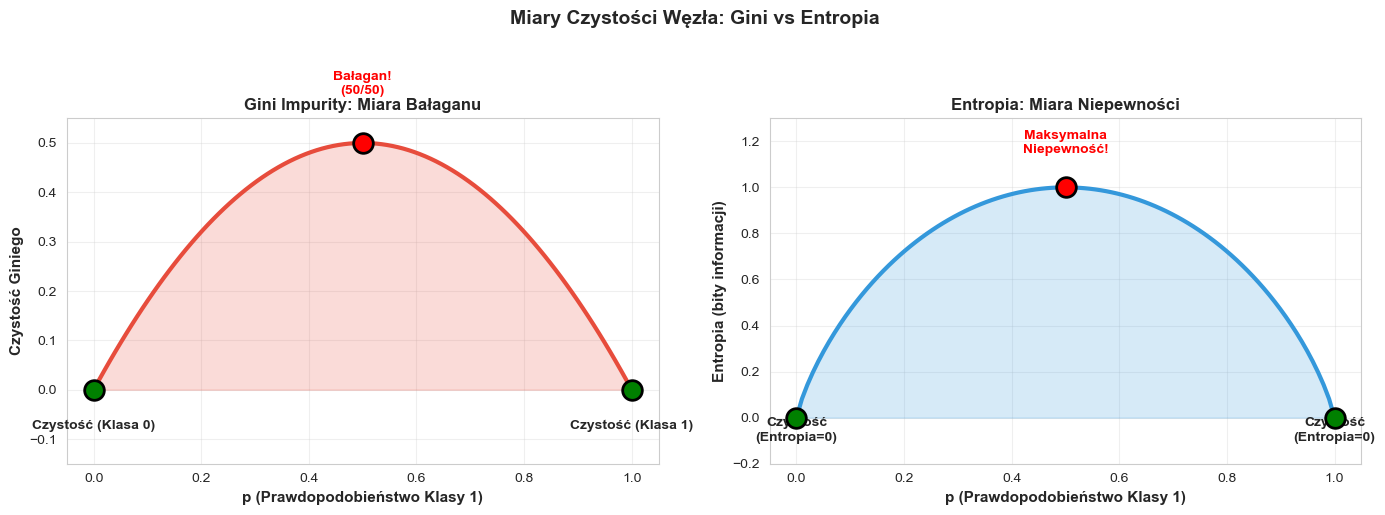


 OBJAŚNIENIE MIAR CZYSTOŚCI:

1. CZYSTOŚĆ GINIEGO (Gini Impurity):
   - Formula: Gini = 1 - (p₁² + p₂²)
   - Czysty węzeł (całkowicie jedna klasa): Gini = 0
   - Bałagan (50/50): Gini = 0.5
   - Interpretacja: Prawdopodobieństwo błędnej klasyfikacji

2. ENTROPIA (Information Entropy):
   - Formula: Entropia = -Σ(pᵢ * log₂(pᵢ))
   - Czysty węzeł: Entropia = 0 (brak informacji do przesyłu)
   - Całkowity bałagan (50/50): Entropia = 1 (maksymalna niepe)
   - Interpretacja: Ilość "bitów" potrzebna do opisania danych

3. PRAKTYCZNIE:
   - Oba działają podobnie w praktyce
   - Gini jest szybszy (nie wymaga logarytmów)
   - Entropia ma bardziej statystyczną interpretację


In [ ]:
# Wizualizacja Giniego i Entropii
p = np.linspace(0, 1, 100)
EPS = 1e-10 # Mała wartość, aby uniknąć problemów numerycznych z log(0)

# Gini impurity (Czystość Giniego) - dla binarna klasyfikacja
# Gini = 1 - (p^2 + (1-p)^2)
gini = 1 - (p**2 + (1-p)**2)

# Entropy (Entropia) - dla binarna klasyfikacja
# Entropia = -p*log2(p) - (1-p)*log2(1-p)
entropy = -np.where(p > 0, p * np.log2(p + EPS), 0) - np.where(1-p > 0, (1-p + EPS) * np.log2((1-p) + EPS), 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gini
ax1 = axes[0]
ax1.plot(p, gini, linewidth=3, color='#e74c3c', label='Czystość Giniego')
ax1.fill_between(p, 0, gini, alpha=0.2, color='#e74c3c')
ax1.scatter([0, 1], [0, 0], s=200, c='green', marker='o', zorder=5, edgecolors='black', linewidth=2)
ax1.scatter([0.5], [0.5], s=200, c='red', marker='o', zorder=5, edgecolors='black', linewidth=2)
ax1.set_xlabel('p (Prawdopodobieństwo Klasy 1)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Czystość Giniego', fontweight='bold', fontsize=11)
ax1.set_title('Gini Impurity: Miara Bałaganu', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.text(0, -0.08, 'Czystość (Klasa 0)', ha='center', fontsize=10, fontweight='bold')
ax1.text(1, -0.08, 'Czystość (Klasa 1)', ha='center', fontsize=10, fontweight='bold')
ax1.text(0.5, 0.6, 'Bałagan!\n(50/50)', ha='center', fontsize=10, fontweight='bold', color='red')
ax1.set_ylim([-0.15, 0.55])

# Entropy
ax2 = axes[1]
ax2.plot(p, entropy, linewidth=3, color='#3498db', label='Entropia')
ax2.fill_between(p, 0, entropy, alpha=0.2, color='#3498db')
ax2.scatter([0, 1], [0, 0], s=200, c='green', marker='o', zorder=5, edgecolors='black', linewidth=2)
ax2.scatter([0.5], [1], s=200, c='red', marker='o', zorder=5, edgecolors='black', linewidth=2)
ax2.set_xlabel('p (Prawdopodobieństwo Klasy 1)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Entropia (bity informacji)', fontweight='bold', fontsize=11)
ax2.set_title('Entropia: Miara Niepewności', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.text(0, -0.1, 'Czystość\n(Entropia=0)', ha='center', fontsize=10, fontweight='bold')
ax2.text(1, -0.1, 'Czystość\n(Entropia=0)', ha='center', fontsize=10, fontweight='bold')
ax2.text(0.5, 1.15, 'Maksymalna\nNiepewność!', ha='center', fontsize=10, fontweight='bold', color='red')
ax2.set_ylim([-0.2, 1.3])

plt.suptitle('Miary Czystości Węzła: Gini vs Entropia',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n OBJAŚNIENIE MIAR CZYSTOŚCI:')
print('\n1. CZYSTOŚĆ GINIEGO (Gini Impurity):')
print('   - Formula: Gini = 1 - (p₁² + p₂²)')
print('   - Czysty węzeł (całkowicie jedna klasa): Gini = 0')
print('   - Bałagan (50/50): Gini = 0.5')
print('   - Interpretacja: Prawdopodobieństwo błędnej klasyfikacji')
print('\n2. ENTROPIA (Information Entropy):')
print('   - Formula: Entropia = -Σ(pᵢ * log₂(pᵢ))')
print('   - Czysty węzeł: Entropia = 0 (brak informacji do przesyłu)')
print('   - Całkowity bałagan (50/50): Entropia = 1 (maksymalna niepewność)')
print('   - Interpretacja: Ilość "bitów" potrzebna do opisania danych')
print('\n3. PRAKTYCZNIE:')
print('   - Oba działają podobnie w praktyce')
print('   - Gini jest szybszy (nie wymaga logarytmów)')
print('   - Entropia ma bardziej statystyczną interpretację')


## Okej, to przejdźmy do przykładu

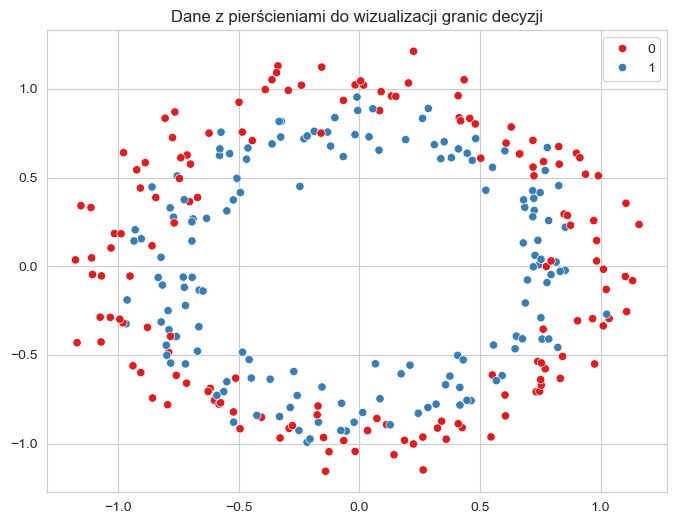

In [7]:
# Dane z pierścieniami (zaszumione) - dobre do wizualizacji
X_circle, y_circle = make_circles(n_samples=300, noise=0.1, random_state=0)

# Jak wyglądają dane?
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_circle[:, 0], y=X_circle[:, 1], hue=y_circle, palette='Set1')
plt.title('Dane z pierścieniami do wizualizacji granic decyzji')
plt.show()

### Efekt głębokości

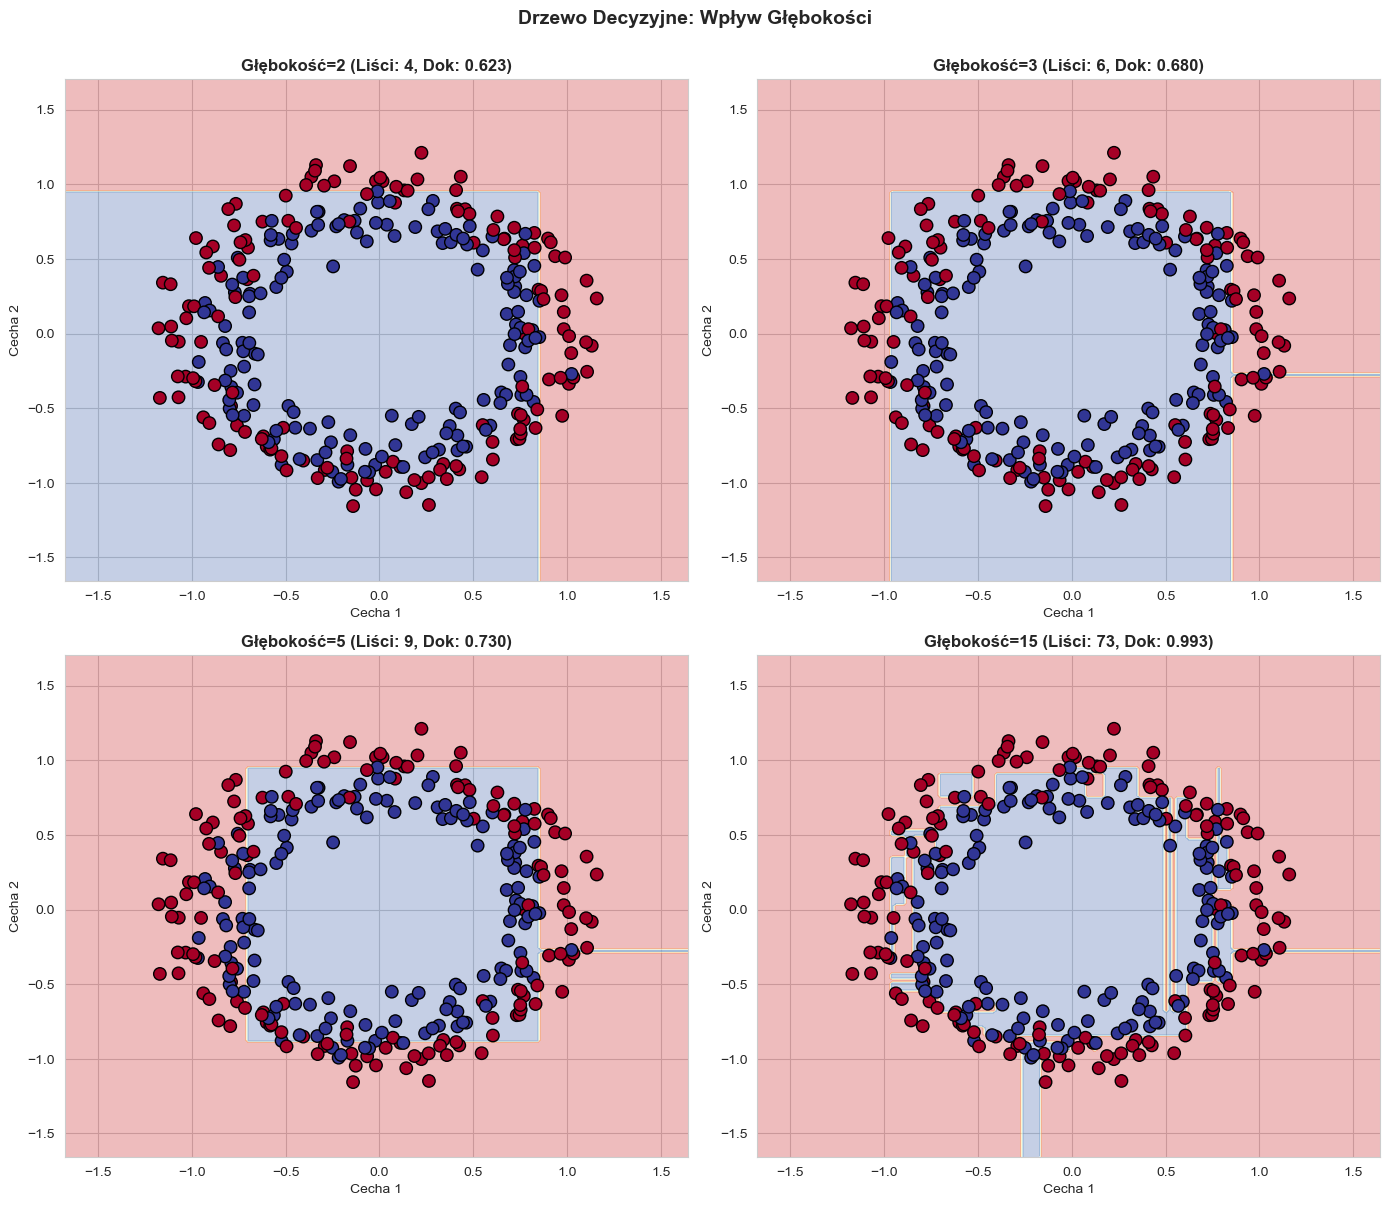

 Obserwacje:
- Liczba prostych podziałów rośnie z głębokością - przeanalizuj kształt granic.
- Głębokość 2-3: Za proste
- Głębokość 5: Wygląda dobrze!
- Głębokość 15: Przeuczenie


In [31]:
# Wizualizacja różnych głębokości
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
depths = [2, 3, 5, 15]

for idx, depth in enumerate(depths):
    ax = axes[idx // 2, idx % 2]
    
    # Trening drzewa
    dt = DecisionTreeClassifier(max_depth=depth, random_state=2211)
    dt.fit(X_circle, y_circle)
    
    # Siatka
    h = 0.02
    x_min = X_circle[:, 0].min() - 0.5
    x_max = X_circle[:, 0].max() + 0.5
    y_min = X_circle[:, 1].min() - 0.5
    y_max = X_circle[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle,
              cmap=plt.cm.RdYlBu, edgecolors='k', s=80)
    
    n_leaves = dt.get_n_leaves()
    acc = dt.score(X_circle, y_circle)
    
    ax.set_title(f'Głębokość={depth} (Liści: {n_leaves}, Dok: {acc:.3f})',
                fontweight='bold')
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')

plt.suptitle('Drzewo Decyzyjne: Wpływ Głębokości',
             fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

print(' Obserwacje:')
print('- Liczba prostych podziałów rośnie z głębokością - przeanalizuj kształt granic.')
print('- Głębokość 2-3: Za proste')
print('- Głębokość 5: Wygląda dobrze!')
print('- Głębokość 15: Przeuczenie')


## Ćwiczenie

### Ćwiczenie 2.1: Sprawdzenie generalizacji
---------------------------------------------------
Zastanów się i sprawdź jak można sprawdzić __niewizualnie__ efekt przeuczenia?

### Ćwiczenie 2.2 Jak wybrać optymalną głębokość?
---------------------------------------------------
Zastanów się nad dwoma technikami, które pozwolą nam zautomatyzować ten proces (bez znalezienia własnych thresholdów)

Zrobisz samemu?

## Rozwiązania:

In [39]:
# 2.1: TRAIN/TEST SPLIT + analiza różnicy

X_train, X_test, y_train, y_test = train_test_split(
    X_circle, y_circle, test_size=0.2, random_state=2211
)

X_train, X_test, y_train, y_test = train_test_split(
    X_circle, y_circle, test_size=0.2, random_state=2211
)

print("\n" + "─"*70)
print("ROZWIĄZANIE: Train/Test Split + Gap Analysis")
print("─"*70)

depths = [2, 3, 5, 10, 15, 20, 25]
train_scores = []
test_scores = []
gaps = []

print(f"\n{'Depth':<8} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<12} {'Status'}")
print("─"*60)

for depth in depths:
    # Trenuj na train set
    dt = DecisionTreeClassifier(max_depth=depth, random_state=2211)
    dt.fit(X_train, y_train)

    # Ewaluacja na train i test
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    gap = train_acc - test_acc

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    gaps.append(gap)

    # Interpretacja
    if train_acc < 0.7:
        status = "Underfitting!"
    elif gap < 0.15:
        status = "OK"
    else:
        status = "Overfitting!"

    print(f"{depth:<8} {train_acc:<12.4f} {test_acc:<12.4f} {gap:<12.4f} {status}")

# 2.2: Użyj CV do wyboru optymalnej głębokości - trzymaj w pamięci best_score i best_depth!


──────────────────────────────────────────────────────────────────────
ROZWIĄZANIE: Train/Test Split + Gap Analysis
──────────────────────────────────────────────────────────────────────

Depth    Train Acc    Test Acc     Gap          Status
────────────────────────────────────────────────────────────
2        0.6375       0.5833       0.0542       Underfitting!
3        0.7125       0.6333       0.0792       OK
5        0.7833       0.6833       0.1000       OK
10       0.9625       0.7000       0.2625       Overfitting!
15       1.0000       0.6333       0.3667       Overfitting!
20       1.0000       0.6333       0.3667       Overfitting!
25       1.0000       0.6333       0.3667       Overfitting!


# W STRONĘ LASÓW - ENSEMBLE MODELS
(po polsku zwane również **uczeniem zespołowym**, zostańmy przy słowie **ensemble**)

### Teoria
**Ensemble learning** to podejście, w którym łączymy wiele niezależnych modeli (np. drzew, klasyfikatorów, regresorów), aby uzyskać lepszą jakość predykcji niż pojedynczy model. 

Kluczowe parametry: **liczba ekspertów**, forma **podziału**, forma **aggregacji**

**Korzyści:**
- Lepsza generalizacja (niższy błąd testowy)
- Mniejsza podatność na przeuczenie
- Możliwość wykorzystania różnych typów modeli

### Klasyczne Analogie:
- **Jeden ekspert** - może się mylić
- **Grupa ekspertów** - zwykle robi lepszą decyzję
- **Różne grupy** - bardziej niezawodne niż jedna grupa

### Techniki:
Najpopularniejsze:
- **Bagging** (np. Random Forest): trenujemy wiele modeli na losowych podzbiorach danych, a wynik to średnia/głosowanie. <-- dziś!
- **Boosting** (np. AdaBoost, XGBoost): kolejne modele uczą się na błędach poprzednich, wzmacniając trudne przypadki. <-- tylko trochę dziś
- **Stacking**: uczymy meta-model, który łączy predykcje kilku różnych algorytmów.

### Próba budowania intuicji

Bardzo prosty przypadek: przewidź wartość funkcji sinus, niestety przy użyciu kilku prostych modeli, np. drzew decyzyjnych z głębokością 5.

Jak to wygląda w praktyce: ENSEMBLE LEARNING Z CROSS-VALIDATION

Dane: 250 próbek
Problem: Regresja sinusa z szumem
Podejście: K-Fold Cross-Validation dla diversitas modeli

Dzielenie danych na 5 foldy...
Każdy fold: 80% train (120 próbek), 20% test (30 próbek)

Fold 1: RMSE = 0.2364 (200 train, 50 test)
Fold 2: RMSE = 0.2795 (200 train, 50 test)
Fold 3: RMSE = 0.2508 (200 train, 50 test)
Fold 4: RMSE = 0.2723 (200 train, 50 test)
Fold 5: RMSE = 0.2299 (200 train, 50 test)

RMSE CV Ensemble: 0.2545
Średni RMSE modeli: 0.2538


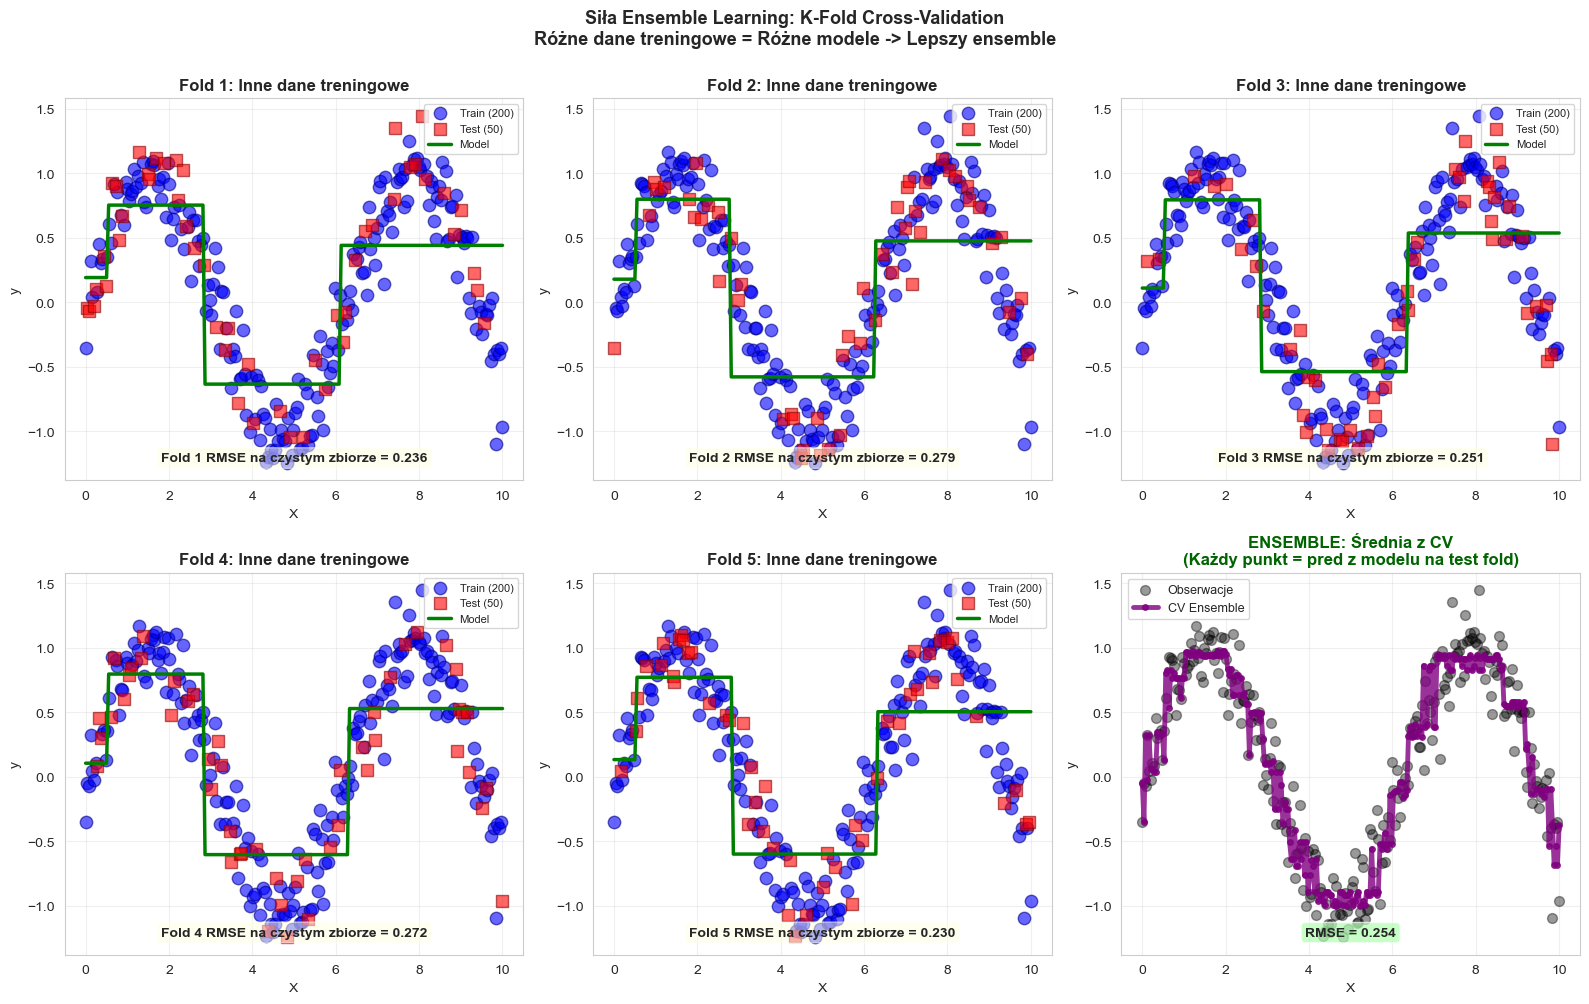


 CO TU SIĘ DZIEJE?

RMSE Pojedynczych Modeli: [0.23640430315167738, 0.2794571094707875, 0.2507569781182437, 0.2722654865950503, 0.22987474358025964]
RMSE Ensemble: 0.254

Ensemble jest lepszy ponieważ:
1. Każdy model ma RÓŻNE błędy
2. Gdy się uśredniają, błędy się znoszą
3. Sygnał zostaje zachowany


In [40]:
# Seed dla reprodukowalności
np.random.seed(97)

# Generowanie danych - funkcja sinusoidalna z szumem
n_samples = 250
X_data = np.linspace(0, 10, n_samples).reshape(-1, 1)
y_data = np.sin(X_data).ravel() + np.random.normal(0, 0.2, n_samples)

print("="*70)
print("Jak to wygląda w praktyce: ENSEMBLE LEARNING Z CROSS-VALIDATION")
print("="*70)
print(f"\nDane: {len(y_data)} próbek")
print("Problem: Regresja sinusa z szumem")
print("Podejście: K-Fold Cross-Validation dla diversitas modeli\n")

# ============================================================================
# KROK 1: K-FOLD CROSS-VALIDATION
# ============================================================================

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=97)

# Zbiór dla predykcji ensemble
predictions_cv = np.zeros(len(y_data))
rmse_per_fold = []

print(f"Dzielenie danych na {n_splits} foldy...")
print(f"Każdy fold: 80% train (120 próbek), 20% test (30 próbek)")
print()

# Trenowanie modelu dla każdego foldu
for fold, (train_idx, test_idx) in enumerate(kf.split(X_data)):
    # Dane treningowe i testowe
    X_train = X_data[train_idx]
    y_train = y_data[train_idx]
    X_test = X_data[test_idx]
    y_test = y_data[test_idx]

    # Trening modelu na tym foldu
    model = DecisionTreeRegressor(max_depth=5, random_state=97)
    model.fit(X_train, y_train)

    # Predykcja na test fold
    y_pred = model.predict(X_test)
    predictions_cv[test_idx] = y_pred

    # Metryka
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_per_fold.append(rmse)

    print(f"Fold {fold+1}: RMSE = {rmse:.4f} ({len(train_idx)} train, {len(test_idx)} test)")

print()
print(f"RMSE CV Ensemble: {np.sqrt(mean_squared_error(y_data, predictions_cv)):.4f}")
print(f"Średni RMSE modeli: {np.mean(rmse_per_fold):.4f}")

# ============================================================================
# KROK 2: WIZUALIZACJA
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Rysuj każdy fold
for fold, (train_idx, test_idx) in enumerate(kf.split(X_data)):
    ax = axes[fold // 3, fold % 3]

    X_train = X_data[train_idx]
    y_train = y_data[train_idx]
    X_test = X_data[test_idx]
    y_test = y_data[test_idx]

    # Trenuj model
    model = DecisionTreeRegressor(max_depth=2, random_state=42)
    model.fit(X_train, y_train)

    # Rysuj dane treningowe (niebieskie)
    ax.scatter(X_train, y_train, alpha=0.6, s=80, 
              label=f'Train ({len(train_idx)})', color='blue', edgecolors='darkblue')
    # Rysuj dane testowe (czerwone)
    ax.scatter(X_test, y_test, alpha=0.6, s=80, 
              label=f'Test ({len(test_idx)})', color='red', edgecolors='darkred', marker='s')

    # Rysuj model
    X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
    y_plot = model.predict(X_plot)
    ax.plot(X_plot, y_plot, 'g-', linewidth=2.5, label='Model')

    rmse = rmse_per_fold[fold]
    ax.text(0.5, 0.05, f'Fold {fold+1} RMSE na czystym zbiorze = {rmse:.3f}', 
           transform=ax.transAxes, ha='center',
           fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

    ax.set_title(f'Fold {fold+1}: Inne dane treningowe', fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Ensemble - ostatni subplot
ax_ens = axes[1, 2]

# Posortuj dla lepszej wizualizacji
sorted_idx = np.argsort(X_data.ravel())
X_sorted = X_data[sorted_idx]
y_true_sorted = y_data[sorted_idx]
y_pred_sorted = predictions_cv[sorted_idx]

ax_ens.scatter(X_data, y_data, alpha=0.4, s=50, label='Obserwacje', color='black')
ax_ens.plot(X_sorted, y_pred_sorted, 'purple', linewidth=3.5, 
           label='CV Ensemble', marker='o', markersize=4, alpha=0.8)

rmse_ensemble = np.sqrt(mean_squared_error(y_data, predictions_cv))
ax_ens.text(0.5, 0.05, f'RMSE = {rmse_ensemble:.3f}', 
           transform=ax_ens.transAxes, ha='center',
           fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#B0FFB0', alpha=0.7))

ax_ens.set_title('ENSEMBLE: Średnia z CV\n(Każdy punkt = pred z modelu na test fold)', 
                fontweight='bold', color='darkgreen')
ax_ens.set_xlabel('X')
ax_ens.set_ylabel('y')
ax_ens.legend(fontsize=9)
ax_ens.grid(True, alpha=0.3)

plt.suptitle('Siła Ensemble Learning: K-Fold Cross-Validation\nRóżne dane treningowe = Różne modele -> Lepszy ensemble',
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('\n CO TU SIĘ DZIEJE?')
print(f'\nRMSE Pojedynczych Modeli: {rmse_per_fold}')
print(f'RMSE Ensemble: {rmse_ensemble:.3f}')
print(f'\nEnsemble jest lepszy ponieważ:')
print(f'1. Każdy model ma RÓŻNE błędy')
print(f'2. Gdy się uśredniają, błędy się znoszą')
print(f'3. Sygnał zostaje zachowany')


# 3. LASY LOSOWE (ang. Random Forest)

## Teoria
Las losowy buduje WIELE drzew na losowych podzbiorach danych.

### Kluczowa idea:
- Każde drzewo jest niezależne
- Losowe błędy się znoszą
- Rezultat: Agregacja (głos większości lub średnia)

### Dlaczego to działa:
- **Zmniejsza wariancję** - wiele niezależnych drzew
- **Zmniejsza przeuczenie** - średniowanie
- **Znaczenie cech** - z jakich cech korzysta las


## Przykład

In [13]:
# Załadowanie danych
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=123
)

# Forma prezentacji zbioru danych
df_wine = pd.DataFrame(X_wine, columns=wine.feature_names)


ZBIÓR DANYCH WINE - EKSPLORACJA

Kształt: (178, 13)
Liczba próbek: 178
Liczba cech: 13
Liczba klas: 3

Rozkład klas:
  Klasa 0: 59 próbek (33.1%)
  Klasa 1: 71 próbek (39.9%)
  Klasa 2: 48 próbek (27.0%)

Statystyki cech:
       alcohol  malic_acid      ash  alcalinity_of_ash  magnesium  \
count  178.000     178.000  178.000            178.000    178.000   
mean    13.001       2.336    2.367             19.495     99.742   
std      0.812       1.117    0.274              3.340     14.282   
min     11.030       0.740    1.360             10.600     70.000   
25%     12.362       1.602    2.210             17.200     88.000   
50%     13.050       1.865    2.360             19.500     98.000   
75%     13.678       3.082    2.558             21.500    107.000   
max     14.830       5.800    3.230             30.000    162.000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count        178.000     178.000               178.000          178.000   
mean  

C:\Users\mateu\AppData\Local\Temp\ipykernel_54436\2062717939.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_by_class, labels=['Klasa 0', 'Klasa 1', 'Klasa 2'])


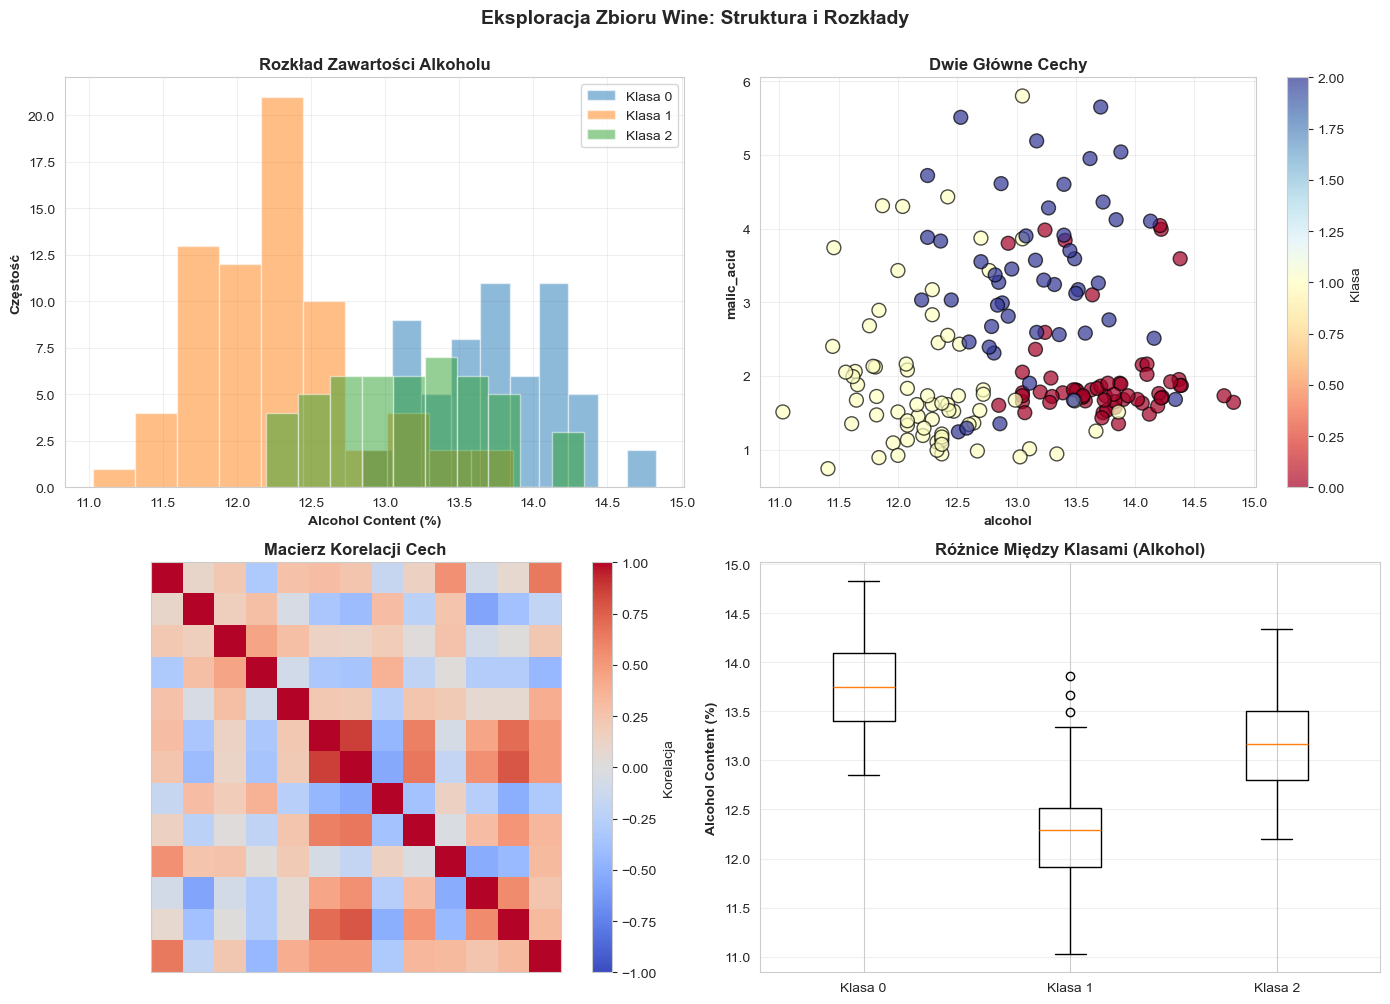


 OBSERWACJE:
- Zbiór jest względnie zrównoważony
- Klasy są wyraźnie separowalne w 2D
- Niektóre cechy mają wysoką korelację


In [14]:
# Załadowanie i eksploracja zbioru Wine
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
df_wine = pd.DataFrame(X_wine, columns=wine.feature_names)
df_wine['klasa'] = y_wine

print('='*70)
print('ZBIÓR DANYCH WINE - EKSPLORACJA')
print('='*70)
print(f'\nKształt: {X_wine.shape}')
print(f'Liczba próbek: {X_wine.shape[0]}')
print(f'Liczba cech: {X_wine.shape[1]}')
print(f'Liczba klas: {len(np.unique(y_wine))}')

print(f'\nRozkład klas:')
for i in np.unique(y_wine):
    count = np.sum(y_wine == i)
    print(f'  Klasa {i}: {count} próbek ({100*count/len(y_wine):.1f}%)')

print(f'\nStatystyki cech:')
print(df_wine.describe().round(3))

# Wizualizacja
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram rozkładu alkoholu
ax1 = axes[0, 0]
for klasa in np.unique(y_wine):
    ax1.hist(X_wine[y_wine == klasa, 0], alpha=0.5, label=f'Klasa {klasa}')
ax1.set_xlabel('Alcohol Content (%)', fontweight='bold')
ax1.set_ylabel('Częstość', fontweight='bold')
ax1.set_title('Rozkład Zawartości Alkoholu', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot dwóch głównych cech
ax2 = axes[0, 1]
scatter = ax2.scatter(X_wine[:, 0], X_wine[:, 1], c=y_wine, 
                      cmap=plt.cm.RdYlBu, s=100, edgecolors='k', alpha=0.7)
ax2.set_xlabel(wine.feature_names[0], fontweight='bold')
ax2.set_ylabel(wine.feature_names[1], fontweight='bold')
ax2.set_title('Dwie Główne Cechy', fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Klasa')
ax2.grid(True, alpha=0.3)

# 3. Korelacja cech
ax3 = axes[1, 0]
corr_matrix = np.corrcoef(X_wine.T)
im = ax3.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax3.set_title('Macierz Korelacji Cech', fontweight='bold')
plt.colorbar(im, ax=ax3, label='Korelacja')
ax3.set_xticks([])
ax3.set_yticks([])

# 4. Box plot - różnica między klasami
ax4 = axes[1, 1]
data_by_class = [X_wine[y_wine == i, 0] for i in range(3)]
bp = ax4.boxplot(data_by_class, labels=['Klasa 0', 'Klasa 1', 'Klasa 2'])
ax4.set_ylabel('Alcohol Content (%)', fontweight='bold')
ax4.set_title('Różnice Między Klasami (Alkohol)', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Eksploracja Zbioru Wine: Struktura i Rozkłady',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f'\n OBSERWACJE:')
print(f'- Zbiór jest względnie zrównoważony')
print(f'- Klasy są wyraźnie separowalne w 2D')
print(f'- Niektóre cechy mają wysoką korelację')


LAS LOSOWY NA ZBIORZE WINE

📊 Wpływ liczby drzew:
    Drzewa |   Dok. treningu |      Dok. testu
---------------------------------------------
         2 |          0.9355 |          0.7222
         3 |          0.9839 |          0.8333
         5 |          1.0000 |          0.8704
         8 |          1.0000 |          0.8889
        10 |          1.0000 |          0.8889
        15 |          1.0000 |          0.9259
        20 |          1.0000 |          0.9074
        30 |          1.0000 |          0.9630
        40 |          1.0000 |          1.0000
        50 |          1.0000 |          0.9815
        75 |          1.0000 |          0.9815
       100 |          1.0000 |          0.9815
       150 |          1.0000 |          0.9815
       200 |          1.0000 |          0.9630


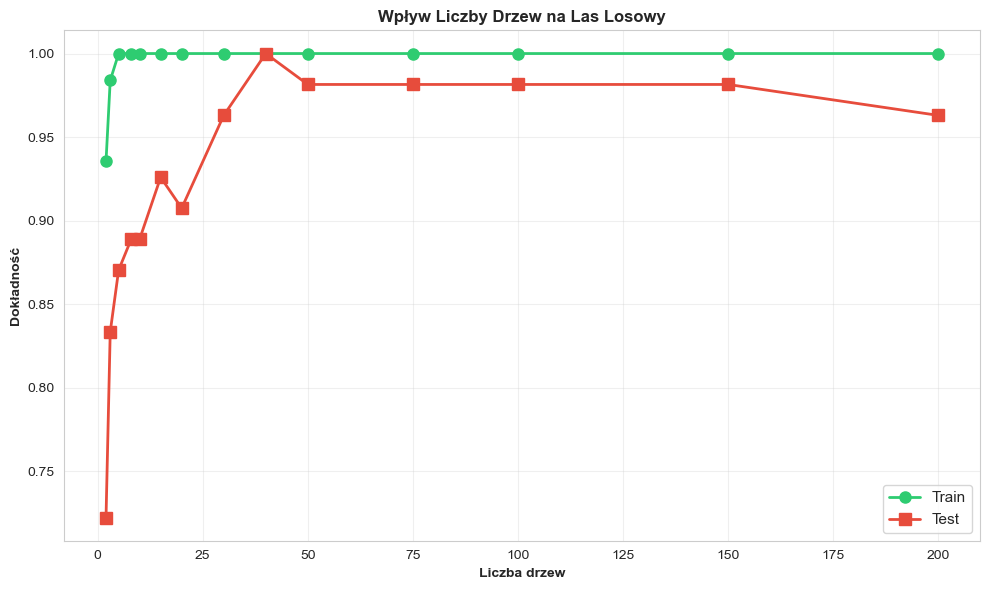

In [15]:
print('='*60)
print('LAS LOSOWY NA ZBIORZE WINE')
print('='*60)

# Testowanie liczby drzew
print('\n📊 Wpływ liczby drzew:')
print(f'{"Drzewa":>10} | {"Dok. treningu":>15} | {"Dok. testu":>15}')
print('-'*45)

results = []
for n_trees in [2, 3, 5, 8, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]:
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=10, random_state=1997)
    rf.fit(X_train, y_train)
    
    train_acc = rf.score(X_train, y_train)
    test_acc = rf.score(X_test, y_test)
    
    results.append({'n_trees': n_trees, 'train': train_acc, 'test': test_acc})
    print(f'{n_trees:10d} | {train_acc:15.4f} | {test_acc:15.4f}')

# Wizualizacja
df_results = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_results['n_trees'], df_results['train'], 'o-', linewidth=2,
        markersize=8, label='Train', color='#2ecc71')
ax.plot(df_results['n_trees'], df_results['test'], 's-', linewidth=2,
        markersize=8, label='Test', color='#e74c3c')

ax.set_xlabel('Liczba drzew', fontweight='bold')
ax.set_ylabel('Dokładność', fontweight='bold')
ax.set_title('Wpływ Liczby Drzew na Las Losowy', fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Stop - musimy tu powiedzieć o czymś ważnym - XGBoost

## XGBoost = eXtreme Gradient Boosting
Iteracyjnie (sekwencyjnie) uczymy modele (tutaj drzewa) na podstawie błędów poprzedników.

## Czemu są ważne?
XGBoost **dominuje** w konkursach Machine Learning (Kaggle, konkursy finansowe).
Ponieważ:
- ✓ Uczy się z błędów poprzednich modeli
- ✓ Zabudowana regularyzacja (nie przeuczyna się tak łatwo)
- ✓ Bardzo efektywne (szybkie trenowanie dużych zbiorów)
- ✓ Często daje lepsze wyniki niż Random Forest

## Porównanie do lasów losowych:

**Bagging (Random Forest):**
- Trenuje drzewa **równolegle** (niezależnie od siebie)
- Każde drzewo uczy się na losowej próbce danych (bootstrap)
- Ostateczna predykcja = średnia predykcji wszystkich drzew
- Redukcja wariancji poprzez uśrednianie

**Boosting (XGBoost):**
- Trenuje drzewa **sekwencyjnie** (jedno po drugim)
- Każde nowe drzewo uczy się od **błędów poprzednich drzew**
- Ostateczna predykcja = **suma** predykcji wszystkich drzew
- Redukcja błędu poprzez sekwencyjną korektę

### Różnice:

| Aspekt | Random Forest | XGBoost |
|--------|---------------|----------|
| Struktura | Równoległa (parallel) | Sekwencyjna (sequential) |
| Próbkowanie | Bootstrap (losowe) | Weighted (z wagami) |
| Kombinacja | Średnia | Suma |
| Regularyzacja | Brak | L1 + L2 (wbudowana) |
| Optymalizacja | Niezależnie | Względem poprzednich błędów |
| Szybkość | Szybko | Powolniej, ale lepsze wyniki |

## Jak działa boosting?

1. Pierwszy uczeń uczy się problemu
2. Robi błędy na trudnych punktach
3. Drugi uczeń uczy się **tylko z punktów, na których pierwszy się mylił**
4. Trzeci uczeń uczy się z błędów pierwszych dwóch
5. I tak dalej...
6. Ostateczna odpowiedź = suma przewidywań wszystkich

**Rezultat:** Każdy kolejny model "naprawia" błędy poprzednich.

## Formalnie:
**Predykcja:**
$$\hat{y} = f_1(x) + f_2(x) + f_3(x) + ... + f_M(x)$$

Gdzie każde $f_i$ jest słabym ucznikiem (małym drzewem).

**Funkcja celu:**
$$\text{Minimalizuj: } \sum_i L(y_i, \hat{y}_i) + \sum_m \Omega(f_m)$$

- Pierwsza część: błąd predykcji (jak dobrze odgadujemy)
- Druga część: regularyzacja (by drzewa były proste)

XGBoost jawnie **regularyzuje** każde drzewo.

## Główne Hiperparametry

- **n_estimators**: Ile drzew uczyć (domyślnie 100)
  - Więcej = lepiej, ale wolniej i ryzyko przeuczenia
  - Zwykle 50-500 dla dobrych wyników

- **max_depth**: Głębokość każdego drzewa (domyślnie 6)
  - Mniejsze = prostsze modele, mniej przeuczenia
  - Zwykle 3-10

- **learning_rate**: Jak szybko się uczyć (domyślnie 0.1)
  - Mniejsze = wolniej, ale może dokładniej
  - Zwykle 0.01-0.3

- **subsample**: Jaki % danych dla każdego drzewa
  - Mniejsze = losowość, lepsze uogólnianie

- **colsample_bytree**: Jaki % cech dla każdego drzewa
  - Mniejsze = różne drzewa patrzą na różne cechy

## Ćwiczenia

In [ ]:
# Tworzenie danych
X, y = make_moons(n_samples=500, noise=0.15, random_state=1997)

# Podział train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1997
)

print(f"Zbiór treningowy: {X_train.shape[0]} próbek")
print(f"Zbiór testowy: {X_test.shape[0]} próbek")
print(f"Liczba cech: {X_train.shape[1]}")
print(f"\nDane są klasą 0: {(y_train == 0).sum()} vs 1: {(y_train == 1).sum()}")

### Ćwiczenie 3.1: Porównanie pojedynczego drzewa z losowym lasem oraz XGBoostem dla głębokości maksymalnej równej 5.
---------------------------------------------------
Uzupełnij:
```
print("="*60)
print("PORÓWNANIE WYDAJNOŚCI NA ZBIORZE TESTOWYM")
print("="*60)
print(f"Decision Tree        | Dokładność: {dt_acc:.4f}")
print(f"Random Forest (50)   | Dokładność: {rf_acc:.4f}")
print(f"XGBoost (50)         | Dokładność: {xgb_acc:.4f}")
print("="*60)
print(f"\nXGBoost lepszy od DT o: {(xgb_acc - dt_acc):.4f}")
print(f"XGBoost lepszy od RF o: {(xgb_acc - rf_acc):.4f}")
```

### Ćwiczenie 3.2: Wizualizacja: jak każdy model podejmuje decyzje.
---------------------------------------------------
Powinieneś móc odtworzyć coś w tym stylu:

<img src="dt_vs_rf_vs_xgboost.png" alt="zad2.2" width="1000"/>

### Ćwiczenie 3.3: Sprawdź efekty parametru learning rate (szybkości uczenia).
---------------------------------------------------
Powinieneś móc odtworzyć coś w tym stylu:

<img src="xgboost_lr.png" alt="zad2.2" width="1000"/>

# 4. REGRESJA LINIOWA

## Teoria

Najprościej, regresja liniowa to znalezienie najlepiej dopasowanej linii do danych.

## Geometria

Wyobraź sobie, że musisz przyłożyć linijkę do danych:


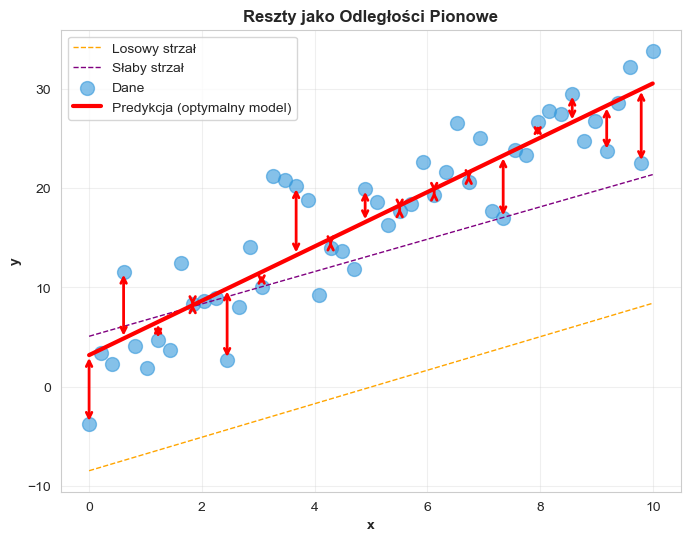

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

np.random.seed(97)
X_simple = np.linspace(0, 10, 50).reshape(-1, 1)
y_simple = 2.5 * X_simple.ravel() + 5 + np.random.normal(0, 5, 50)

# Słabe próby przyłożenia linijki
random_slope, random_intercept = np.random.uniform(0.5, 4.0), np.random.uniform(-5, 15)
weak_slope = np.random.uniform(1.5, 3.5)
weak_intercept = np.random.uniform(-10, 20)
y_rand = weak_slope * X_simple + weak_intercept
y_weak = random_slope * X_simple + random_intercept
ax.plot(X_simple, y_rand, linestyle='--', color='orange', linewidth=1, label='Losowy strzał')
ax.plot(X_simple, y_weak, linestyle='--', color='purple', linewidth=1, label='Słaby strzał')

# Uniknij powielania legendy
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

# Trening modelu - model parametryczny
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)
y_pred_simple = model_simple.predict(X_simple)

# Plot 1: Dane + linia + reszty (strzałki)
ax.scatter(X_simple, y_simple, s=100, alpha=0.6, color='#3498db', label='Dane')
ax.plot(X_simple, y_pred_simple, 'r-', linewidth=3, label='Predykcja (optymalny model)')
# Strzałki pokazujące reszty
for i in range(0, len(X_simple), 3):
    x = X_simple[i, 0]
    y = y_simple[i]
    y_pred = y_pred_simple[i]
    
    residual = y - y_pred
    ax.annotate('', xy=(x, y_pred), xytext=(x, y),
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))

ax.set_xlabel('x', fontweight='bold')
ax.set_ylabel('y', fontweight='bold')
ax.set_title('Reszty jako Odległości Pionowe', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

## Matematyka jest trywialna:
```
ŷ = β₀ + β₁·x

gdzie:
- ŷ        : Przewidywana wartość
- β₀       : Wyraz wolny (intercept) - gdzie linia przecina oś Y
- β₁       : Nachylenie (slope) - jak bardzo się zmienia Y na jednostkę X
- x        : Wartość cechy wejściowej
```

Minimalizuj sumę kwadratów reszt (Least Squares):
```
SSE = Σ(yᵢ - ŷᵢ)²

lub równoważnie:
MSE = (1/n) · Σ(yᵢ - ŷᵢ)²  ← Średni Błąd Kwadratowy
```

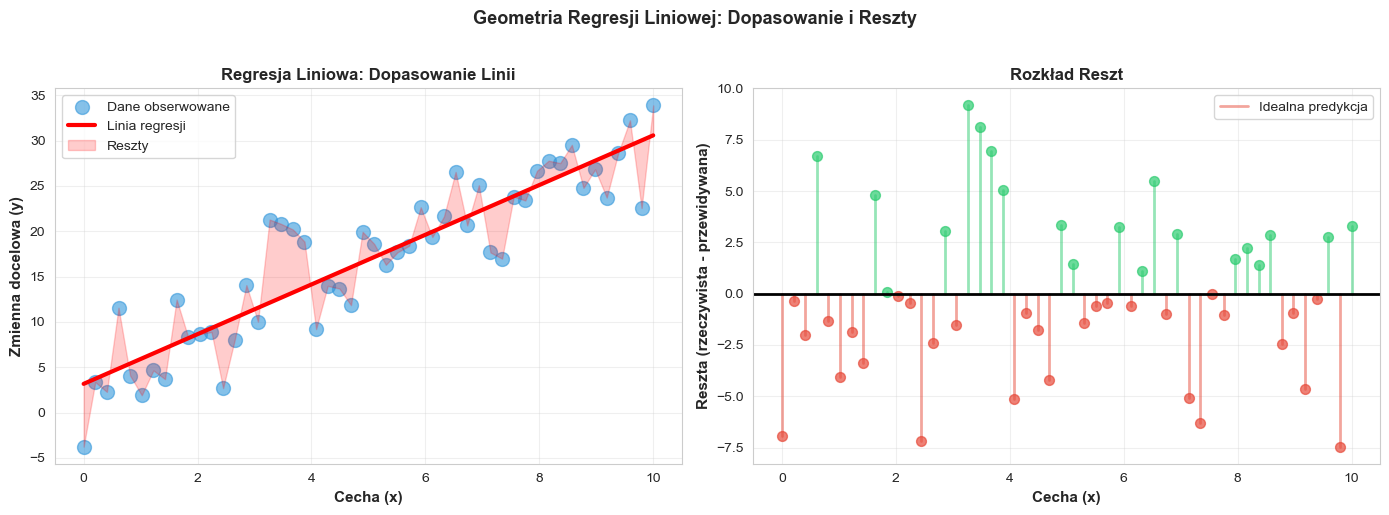

STATYSTYKI MODELU

Wyraz wolny (β₀): 3.1697
Nachylenie (β₁):  2.7402

Równanie linii: y = 2.7402 * x + 3.1697

Meryk Błędu:
  MSE (Średni Błąd Kwadratowy):  14.9934
  RMSE (Pierwiastek MSE):        3.8721
  MAE (Średni Błąd Absolutny):   3.0326
  R² (Procent wyjaśnionej wariancji): 0.8129

 INTERPRETACJA:
- Na każdy wzrost x o 1 jednostkę, y wzrasta średnio o 2.7402
- Średnia wielkość błędu predykcji: 3.87
- Model wyjaśnia 81.3% zmienności w y


In [17]:
# Generowanie syntetycznych danych
np.random.seed(97)
X_simple = np.linspace(0, 10, 50).reshape(-1, 1)
y_simple = 2.5 * X_simple.ravel() + 5 + np.random.normal(0, 5, 50)  # y = 2.5*x + 5 + szum

# Trening modelu
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)
y_pred_simple = model_simple.predict(X_simple)

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lewy plot - Dopasowanie linii
ax1 = axes[0]
ax1.scatter(X_simple, y_simple, s=100, alpha=0.6, color='#3498db', label='Dane obserwowane')
ax1.plot(X_simple, y_pred_simple, 'r-', linewidth=3, label='Linia regresji')
ax1.fill_between(X_simple.ravel(), y_simple, y_pred_simple, alpha=0.2, color='red', label='Reszty')

ax1.set_xlabel('Cecha (x)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Zmienna docelowa (y)', fontweight='bold', fontsize=11)
ax1.set_title('Regresja Liniowa: Dopasowanie Linii', fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Prawy plot - Reszty (residuals)
ax2 = axes[1]
residuals = y_simple - y_pred_simple

# Linia residualna
for i, (x, r) in enumerate(zip(X_simple.ravel(), residuals)):
    if r > 0:
        color = '#2ecc71'  # zielony - przewidywanie za niskie
    else:
        color = '#e74c3c'  # czerwony - przewidywanie za wysokie
    ax2.plot([x, x], [0, r], color=color, linewidth=2, alpha=0.5)
    ax2.scatter(x, r, s=50, color=color, alpha=0.7)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=2, label='Idealna predykcja')
ax2.set_xlabel('Cecha (x)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Reszta (rzeczywista - przewidywana)', fontweight='bold', fontsize=11)
ax2.set_title('Rozkład Reszt', fontweight='bold', fontsize=12)
ax2.legend(['Idealna predykcja'], fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Geometria Regresji Liniowej: Dopasowanie i Reszty',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Statystyki modelu
print('='*70)
print('STATYSTYKI MODELU')
print('='*70)
print(f'\nWyraz wolny (β₀): {model_simple.intercept_:.4f}')
print(f'Nachylenie (β₁):  {model_simple.coef_[0]:.4f}')
print(f'\nRównanie linii: y = {model_simple.coef_[0]:.4f} * x + {model_simple.intercept_:.4f}')

mse = mean_squared_error(y_simple, y_pred_simple)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_simple, y_pred_simple)
r2 = r2_score(y_simple, y_pred_simple)

print(f'\nMeryk Błędu:')
print(f'  MSE (Średni Błąd Kwadratowy):  {mse:.4f}')
print(f'  RMSE (Pierwiastek MSE):        {rmse:.4f}')
print(f'  MAE (Średni Błąd Absolutny):   {mae:.4f}')
print(f'  R² (Procent wyjaśnionej wariancji): {r2:.4f}')

print(f'\n INTERPRETACJA:')
print(f'- Na każdy wzrost x o 1 jednostkę, y wzrasta średnio o {model_simple.coef_[0]:.4f}')
print(f'- Średnia wielkość błędu predykcji: {rmse:.2f}')
print(f'- Model wyjaśnia {100*r2:.1f}% zmienności w y')


### Anscombe's Quartet
No właśnie, czy wystarczy patrzeć na główne statystyki danych? Przeanalizujmy znany przykład:

ANSCOMBE'S QUARTET - IDENTYCZNE STATYSTYKI, RÓŻNE DANE

Dataset 1:
  Średnia X: 9.00
  Średnia Y: 7.50
  Wariancja X: 10.00
  Wariancja Y: 3.75
  Korelacja: 0.816
  Linia regresji: y = 0.50*x + 3.00

Dataset 2:
  Średnia X: 9.00
  Średnia Y: 7.50
  Wariancja X: 10.00
  Wariancja Y: 3.75
  Korelacja: 0.816
  Linia regresji: y = 0.50*x + 3.00

Dataset 3:
  Średnia X: 9.00
  Średnia Y: 7.50
  Wariancja X: 10.00
  Wariancja Y: 3.75
  Korelacja: 0.816
  Linia regresji: y = 0.50*x + 3.00

Dataset 4:
  Średnia X: 9.00
  Średnia Y: 7.50
  Wariancja X: 10.00
  Wariancja Y: 3.75
  Korelacja: 0.817
  Linia regresji: y = 0.50*x + 3.00

 WSZYSTKO WYGLĄDA IDENTYCZNIE! ALE...


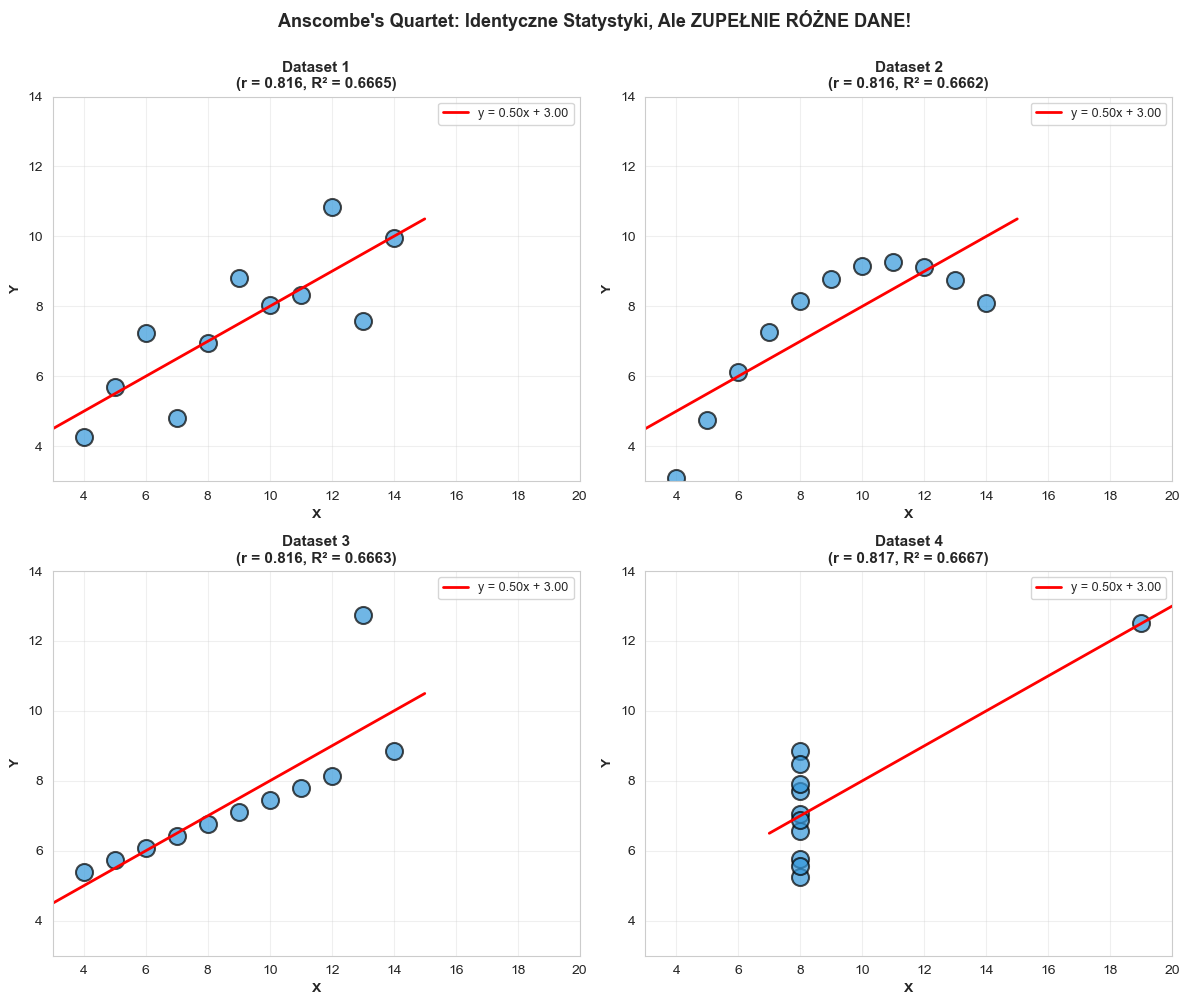


 OBSERWACJE:

Dataset 1: dane mają liniowy trend - regresja liniowa OK
Dataset 2: Zależność już nie jest taka prosta - regresja liniowa niedostateczna
Dataset 3: Perfekcyjna zależność (liniowa) + jeden outlier!
Dataset 4: Outlier zmienia całą linię regresji

 LEKCJA: Statystyki mogą być MYLĄCE!


In [44]:
# Anscombe's Quartet - klasyczny dataset

# Dane Anscombe'a
data = {
    'x1': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
    'y1': [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    'x2': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
    'y2': [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74],
    'x3': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
    'y3': [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    'x4': [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8],
    'y4': [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89],
}

# Obliczanie statystyk
print('='*80)
print('ANSCOMBE\'S QUARTET - IDENTYCZNE STATYSTYKI, RÓŻNE DANE')
print('='*80)

for i in range(1, 5):
    x = np.array(data[f'x{i}'])
    y = np.array(data[f'y{i}'])
    
    # Statystyki
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x)
    var_y = np.var(y)
    corr = np.corrcoef(x, y)[0, 1]
    
    # Regresja
    slope = np.sum((x - mean_x) * (y - mean_y)) / np.sum((x - mean_x)**2)
    intercept = mean_y - slope * mean_x
    
    print(f'\nDataset {i}:')
    print(f'  Średnia X: {mean_x:.2f}')
    print(f'  Średnia Y: {mean_y:.2f}')
    print(f'  Wariancja X: {var_x:.2f}')
    print(f'  Wariancja Y: {var_y:.2f}')
    print(f'  Korelacja: {corr:.3f}')
    print(f'  Linia regresji: y = {slope:.2f}*x + {intercept:.2f}')

print(f'\n WSZYSTKO WYGLĄDA IDENTYCZNIE! ALE...')

# Wizualizacja
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(1, 5):
    ax = axes[i-1]
    
    x = np.array(data[f'x{i}'])
    y = np.array(data[f'y{i}'])
    
    # Dane
    ax.scatter(x, y, s=150, color='#3498db', alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Linia regresji
    x_line = np.linspace(x.min() - 1, x.max() + 1, 100)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    slope = np.sum((x - mean_x) * (y - mean_y)) / np.sum((x - mean_x)**2)
    intercept = mean_y - slope * mean_x
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')
    
    # Statystyki w tytule
    corr = np.corrcoef(x, y)[0, 1]
    ax.set_title(f'Dataset {i}\n(r = {corr:.3f}, R² = {corr**2:.4f})', fontweight='bold', fontsize=11)
    ax.set_xlabel('X', fontweight='bold')
    ax.set_ylabel('Y', fontweight='bold')
    ax.set_xlim([3, 20])
    ax.set_ylim([3, 14])
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Anscombe\'s Quartet: Identyczne Statystyki, Ale ZUPEŁNIE RÓŻNE DANE!',
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('\n OBSERWACJE:')
print('\nDataset 1: dane mają liniowy trend - regresja liniowa OK')
print('Dataset 2: Zależność już nie jest taka prosta - regresja liniowa niedostateczna')
print('Dataset 3: Perfekcyjna zależność (liniowa) + jeden outlier!')
print('Dataset 4: Outlier zmienia całą linię regresji')
print('\n LEKCJA: Statystyki mogą być MYLĄCE!')


## Rozszerzenie do nieliniowości

Problem: Nie Wszystkie Dane Są Liniowe!

Dotychczas:
```
ŷ = β₀ + β₁·x

To najprośtsza funkcja - linia prosta.
```

Zamiast linii, użyjmy WIELOMIANU:
```
Stopień 1 (liniowa):
  ŷ = β₀ + β₁·x

Stopień 2 (funkcja kwadratowa):
  ŷ = β₀ + β₁·x + β₂·x²

Stopień 3 (funkcja sześcienna):
  ŷ = β₀ + β₁·x + β₂·x² + β₃·x³

Stopień n:
  ŷ = β₀ + β₁·x + β₂·x² + ... + βₙ·xⁿ
```

Trik: Budujemy "wiele cech"

Zamiast:
```
  [x₁, x₂, x₃] = [2, 3, 5]  (3 features)
```

Możemy traktować:
```
  [1, x, x²] = [1, 2, 4]  (3 "features")
```

To jest **LINIOWA regresja** na transformowanych cechach!


__Uwaga: Nie Mieszaj Terminów!__

- **Forma funkcji**: Wielomianowa ($x^2$) - NIELINIOWA
- **Forma modelu**: Liniowa względem współczynników - LINIOWA

Tak więc regresja wielomianowa jest LINIOWA względem $\beta$ (uczących parametrów)!

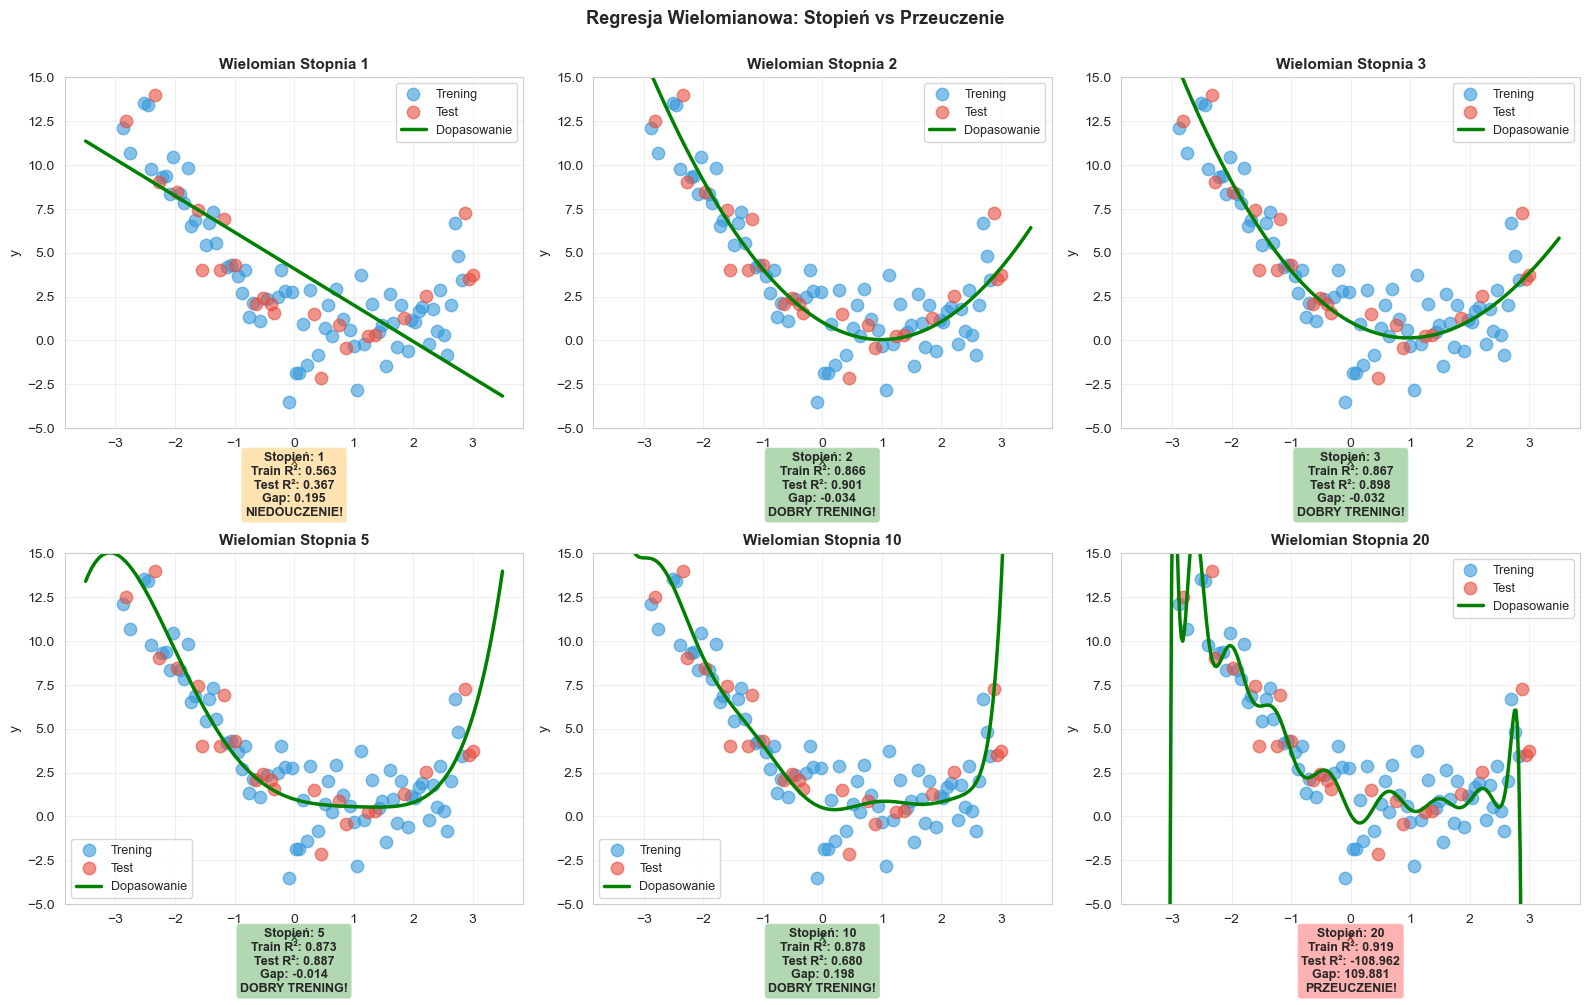


 OBSERWACJE:

Stopień 1 (liniowa):
- NIEDOUCZENIE: linia nie może uchwycić paraboli

Stopień 2 (kwadratowa):
- DOSKONALE! Odpowiada rzeczywistym danym
- Mały gap między treningiem a testem

Stopień 3-5:
- Nadal dobre, ale zaczyna oscylować

Stopień 10+:
- PRZEUCZENIE: mała i różna model "zapamiętuje" szum
- Duży gap między treningiem a testem

 LEKCJA: Wysoki stopień ≠ lepszy model!


In [ ]:
# Demonstracja regresji wielomianowej
np.random.seed(8)
n_data = 100

# Generowanie danych o kształcie paraboli
X_poly = np.linspace(-3, 3, n_data).reshape(-1, 1)
y_poly = X_poly.ravel()**2 - 2*X_poly.ravel() + 1 + np.random.normal(0, 1.5, n_data)
# Podział
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y_poly, test_size=0.25, random_state=8
)

# Wizualizacja różnych stopni wielomianów
degrees = [1, 2, 3, 5, 10, 20]
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

X_plot = np.linspace(X_poly.min() - 0.5, X_poly.max() + 0.5, 300).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    
    # Transformacja cech - dodaj x, x², x³, itd.
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly_transformed = poly_features.fit_transform(X_train_poly)
    X_test_poly_transformed = poly_features.transform(X_test_poly)
    X_plot_transformed = poly_features.transform(X_plot)
    
    # Trening
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly_transformed, y_train_poly)
    
    # Predykcje
    y_train_pred_poly = model_poly.predict(X_train_poly_transformed)
    y_test_pred_poly = model_poly.predict(X_test_poly_transformed)
    y_plot_poly = model_poly.predict(X_plot_transformed)
    
    # Metryki
    train_r2 = r2_score(y_train_poly, y_train_pred_poly)
    test_r2 = r2_score(y_test_poly, y_test_pred_poly)
    
    # Rysowanie
    ax.scatter(X_train_poly, y_train_poly, s=80, alpha=0.6, color='#3498db', label='Trening')
    ax.scatter(X_test_poly, y_test_poly, s=80, alpha=0.6, color='#e74c3c', label='Test')
    ax.plot(X_plot, y_plot_poly, 'g-', linewidth=2.5, label='Dopasowanie')
    
    # Uproszczenie interpretacji
    gap = train_r2 - test_r2
    if train_r2 < 0.8:
        problem = 'NIEDOUCZENIE!'
        color = 'orange'
    elif gap > 0.2:
        problem = 'PRZEUCZENIE!'
        color = 'red'
    else:
        problem = 'DOBRY TRENING!'
        color = 'green'
    
    textstr = f'Stopień: {degree}\nTrain R²: {train_r2:.3f}\nTest R²: {test_r2:.3f}\nGap: {gap:.3f}\n{problem}'
    ax.text(0.5, -0.25, textstr, transform=ax.transAxes,
           ha='center', fontsize=9, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    ax.set_title(f'Wielomian Stopnia {degree}', fontweight='bold', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-5, 15])

plt.suptitle('Regresja Wielomianowa: Stopień vs Przeuczenie',
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('\n OBSERWACJE:')
print('\nStopień 1 (liniowa):')
print('- NIEDOUCZENIE: linia nie może uchwycić paraboli')
print('\nStopień 2 (kwadratowa):')
print('- DOSKONALE! Odpowiada rzeczywistym danym')
print('- Mały gap między treningiem a testem')
print('\nStopień 3-5:')
print('- Nadal dobre, ale zaczyna oscylować')
print('\nStopień 10+:')
print('- PRZEUCZENIE: mała i różna model "zapamiętuje" szum')
print('- Duży gap między treningiem a testem')
print('\n LEKCJA: Wysoki stopień ≠ lepszy model! (przypomina Ci to coś..?)')


---

Teaser dla SVM:

Negative class projection range: 0.9150 to 1.6238
Positive class projection range: 2.8542 to 4.1408
Support line (neg): 1.6238
Support line (pos): 2.8542
Hyperplane: 2.2390
Margin width: -1.2304


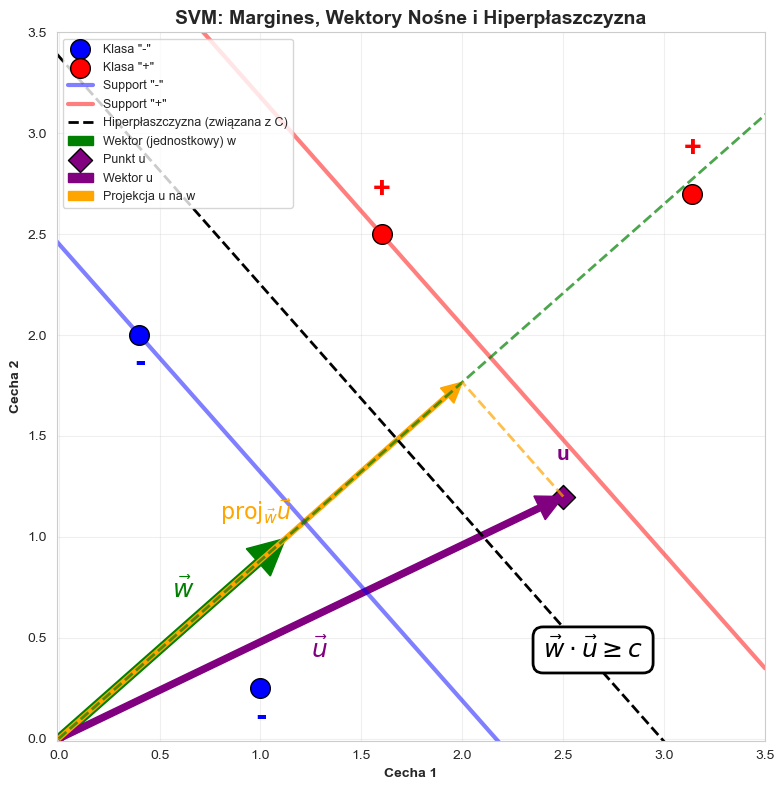

In [ ]:
### KOD DLA PROWADZĄCEGO - omiń! popatrz tylko na wizualizacje ###

neg_points = np.array([[1, 0.25], [0.4, 2]])
pos_points = np.array([[1.6, 2.5], [3.14, 2.7]])

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(neg_points[:, 0], neg_points[:, 1], color='blue', s=200, marker='o', edgecolors='k', label='Klasa "-"')
for pt in neg_points:
    ax.text(pt[0], pt[1]-0.18, '-', color='blue', fontsize=22, fontweight='bold', ha='center')

ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', s=200, marker='o', edgecolors='k', label='Klasa "+"')
for pt in pos_points:
    ax.text(pt[0], pt[1]+0.18, '+', color='red', fontsize=22, fontweight='bold', ha='center')

center_neg = neg_points.mean(axis=0)
center_pos = pos_points.mean(axis=0)

w_dir = center_pos - center_neg
w_unit = w_dir / np.linalg.norm(w_dir)

proj_neg = neg_points @ w_unit
proj_pos = pos_points @ w_unit

closest_neg_idx = np.argmax(proj_neg)
closest_neg_proj = proj_neg[closest_neg_idx]

closest_pos_idx = np.argmin(proj_pos)
closest_pos_proj = proj_pos[closest_pos_idx]

support_neg_pos = closest_neg_proj
support_pos_pos = closest_pos_proj
hyperplane_pos = (closest_neg_proj + closest_pos_proj) / 2

print(f"Negative class projection range: {proj_neg.min():.4f} to {proj_neg.max():.4f}")
print(f"Positive class projection range: {proj_pos.min():.4f} to {proj_pos.max():.4f}")
print(f"Support line (neg): {support_neg_pos:.4f}")
print(f"Support line (pos): {support_pos_pos:.4f}")
print(f"Hyperplane: {hyperplane_pos:.4f}")
print(f"Margin width: {support_neg_pos - support_pos_pos:.4f}")

perp = np.array([-w_unit[1], w_unit[0]])

point_neg = support_neg_pos * w_unit
point_pos = support_pos_pos * w_unit
point_hyp = hyperplane_pos * w_unit

x_vals = np.linspace(-0.5, 3.5, 100)

if abs(perp[0]) > 1e-10:
    y_neg = point_neg[1] + (perp[1] / perp[0]) * (x_vals - point_neg[0])
    ax.plot(x_vals, y_neg, color='blue', linewidth=3, alpha=0.5, label='Support "-"')
    
    y_pos = point_pos[1] + (perp[1] / perp[0]) * (x_vals - point_pos[0])
    ax.plot(x_vals, y_pos, color='red', linewidth=3, alpha=0.5, label='Support "+"')
    
    y_hyp = point_hyp[1] + (perp[1] / perp[0]) * (x_vals - point_hyp[0])
    ax.plot(x_vals, y_hyp, color='black', linestyle='--', linewidth=2, label='Hiperpłaszczyzna (związana z C)')

w_vec = w_unit * 1.5
ax.arrow(0, 0, w_vec[0], w_vec[1], width=0.04, head_width=0.18, head_length=0.18,
         color='green', length_includes_head=True, label='Wektor (jednostkowy) w')
ax.text(w_vec[0]/2, w_vec[1]/2 + 0.2, r'$\vec{w}$', color='green', fontsize=18, fontweight='bold')

end_x = 5.5 * w_unit[0]
end_y = 5.5 * w_unit[1]
ax.plot([0, end_x], [0, end_y], color='green', linestyle='--', linewidth=2, alpha=0.7)

u_point = np.array([2.5, 1.2])
ax.scatter(u_point[0], u_point[1], color='purple', s=150, marker='D', edgecolors='k', label='Punkt u')
ax.text(u_point[0], u_point[1]+0.18, 'u', color='purple', fontsize=15, fontweight='bold', ha='center')

u_vec = u_point
ax.arrow(0, 0, u_vec[0], u_vec[1], width=0.03, head_width=0.13, head_length=0.13,
         color='purple', length_includes_head=True, label='Wektor u')
ax.text(u_vec[0]/2, u_vec[1]/2 - 0.2, r'$\vec{u}$', color='purple', fontsize=18, fontweight='bold')

proj_length = np.dot(u_vec, w_unit)
proj_vec = proj_length * w_unit
ax.arrow(0, 0, proj_vec[0], proj_vec[1], width=0.02, head_width=0.1, head_length=0.1,
         color='orange', length_includes_head=True, label='Projekcja u na w')
ax.text(proj_vec[0]/2 - 0.2, proj_vec[1]/2 + 0.2, r'$\mathrm{proj}_{\vec{w}} \vec{u}$', color='orange', fontsize=16, fontweight='bold')

ax.plot([u_point[0], proj_vec[0]], [u_point[1], proj_vec[1]], color='orange', linestyle='--', linewidth=2, alpha=0.7)

bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2)
ax.text(2.4, 0.4, r'$\vec{w} \cdot \vec{u} \geq c$', fontsize=18, color='black', fontweight='bold', bbox=bbox_props)

ax.set_xlim(-0.01, 3.5)
ax.set_ylim(-0.01, 3.5)
ax.set_aspect('equal')
ax.set_xlabel('Cecha 1', fontweight='bold')
ax.set_ylabel('Cecha 2', fontweight='bold')
ax.set_title('SVM: Margines, Wektory Nośne i Hiperpłaszczyzna', fontweight='bold', fontsize=14)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. MASZYNY WEKTORÓW NOŚNYCH (ang. SVM)

## Teoria
SVM szuka hiperpłaszczyzny o maksymalnym marginesie między klasami.

### Kluczowe pojęcia:
- **Margin**: Odległość między hiperpłaszczyzną a najbliższymi punktami
- **Wektory nośne**: Punkty na granicy marginesu
- ~~Jądra~~ **Kernels**: Sztuczka do obsługi danych nieliniowych

### Ważne parametry:
- **C**: Siła regularyzacji (mniejsze C = większy margines, większa tolerancja na błędy; większe C = mniejszy margines, mniej błędów)
- **gamma** / **degree** (przykład hyperparametrów dla konkretnych kerneli) :  
   Dla kerneli RBF/poly – określa wpływ pojedynczego punktu (małe gamma = szeroki wpływ, duże gamma = wąski wpływ) / stopień wielomianu.
- **class_weight**: Waga klas (przy niezbalansowanych danych)
- **tol**: Tolerancja dla kryterium zatrzymania

_Te parametry mają duży wpływ na granice decyzji i generalizację modelu!_

_WAŻNE: Zawsze normalizuj cechy dla SVM!_


## Wizualizacja
Wizualizacja uczenia się SVM - marginy i wektory nośne. __Zmień__ *noisy_variant*

C=0.01: Margin=2.898, Train Error=0.000
C=0.1: Margin=1.771, Train Error=0.000
C=1: Margin=1.402, Train Error=0.000
C=10: Margin=1.309, Train Error=0.000
C=100: Margin=1.309, Train Error=0.000


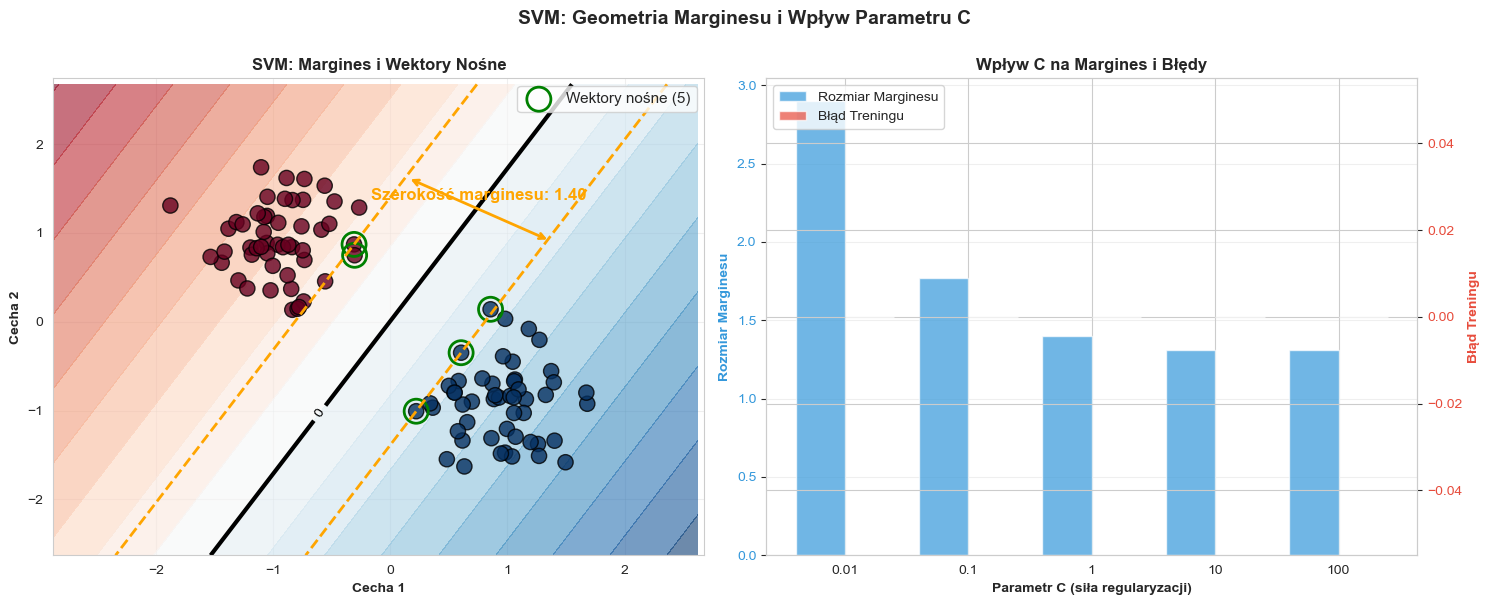


 WYJAŚNIENIE:

1. WEKTORY NOŚNE (zielone koła):
   - Punkty leżące na granicy marginesu
   - Tylko te punkty wpływają na pozycję hiperpłaszczyzny
   - Pozostałe punkty mogą być ignorowane

2. MARGINES (pomarańczowa strzałka):
   - Przestrzeń między klasami
   - Większy margines = lepsze uogólnienie
   - SVM maksymalizuje rozmiar marginesu

3. PARAMETR C:
   - C małe (0.01): Duży margines, tolerujemy błędy
   - C duże (100): Mały margines, brak tolerancji


In [46]:
noisy_variant = False # Ustaw na True, aby zobaczyć wariant z hałasem


n_samples = 100 # Ładniejsza wizualizacja
cluster_std = 1.5 # Liniowo separowalne dane

if noisy_variant:
    n_samples = 200
    cluster_std = 3.14

X_svm_demo, y_svm_demo = make_blobs(n_samples=n_samples, centers=2, 
                                     n_features=2, random_state=42, 
                                     cluster_std=cluster_std)
X_svm_demo = StandardScaler().fit_transform(X_svm_demo)

# Trening SVM
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_svm_demo, y_svm_demo)

# Wizualizacja marginesu i wektorów nośnych
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Lewy plot - Wektory nośne i margines
ax1 = axes[0]

# Siatka
h = 0.1
x_min = X_svm_demo[:, 0].min() - 1
x_max = X_svm_demo[:, 0].max() + 1
y_min = X_svm_demo[:, 1].min() - 1
y_max = X_svm_demo[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Funkcja decyzji
Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Rysowanie konturów
ax1.contourf(xx, yy, Z, levels=20, cmap=plt.cm.RdBu, alpha=0.6)
contours = ax1.contour(xx, yy, Z, levels=[0], colors='black', linewidths=3)
ax1.clabel(contours, inline=True, fontsize=10)

# Marginy (Z = -1 i Z = +1)
ax1.contour(xx, yy, Z, levels=[-1, 1], colors='orange', linewidths=2, linestyles='dashed')

# Szerokość marginesu + rysunek strzałkki
w = svm_model.coef_[0]
margin_width = 2 / np.linalg.norm(w)
mid_x = (x_min + x_max) / 2 + 0.15
mid_y = (y_min + y_max) / 2
w_unit = w / np.linalg.norm(w)
parallel_dir = np.array([-w_unit[1], w_unit[0]])
offset = 1.4 
arrow_start = np.array([mid_x, mid_y]) - w_unit * (margin_width / 2) + parallel_dir * offset
arrow_end = np.array([mid_x, mid_y]) + w_unit * (margin_width / 2) + parallel_dir * offset
ax1.annotate('', xy=arrow_start, xytext=arrow_end,
             arrowprops=dict(arrowstyle='<->', color='orange', linewidth=2))
ax1.text(mid_x + parallel_dir[0]*offset, mid_y + parallel_dir[1]*offset + 0.1, 
         f'Szerokość marginesu: {margin_width:.2f}', 
         fontsize=12, fontweight='bold', color='orange', ha='center')

# Dane
ax1.scatter(X_svm_demo[:, 0], X_svm_demo[:, 1], c=y_svm_demo,
           cmap=plt.cm.RdBu, edgecolors='k', s=120, alpha=0.8)

# Wektory nośne
support_vectors = svm_model.support_vectors_
ax1.scatter(support_vectors[:, 0], support_vectors[:, 1],
           s=300, linewidth=2, facecolors='none', edgecolors='green', 
           label=f'Wektory nośne ({len(support_vectors)})')

ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
ax1.set_xlabel('Cecha 1', fontweight='bold')
ax1.set_ylabel('Cecha 2', fontweight='bold')
ax1.set_title('SVM: Margines i Wektory Nośne', fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Prawy plot - Wpływ C na rozmiar marginesu
ax2 = axes[1]

C_values = [0.01, 0.1, 1, 10, 100]
margins = []
errors = []

for C in C_values:
    svm_c = SVC(kernel='linear', C=C, random_state=42)
    svm_c.fit(X_svm_demo, y_svm_demo)
    
    # Rozmiar marginesu (1 / ||w||)
    w = svm_c.coef_[0]
    margin = 2 / np.linalg.norm(w)
    margins.append(margin)
    
    # Błąd treningowy
    train_error = 1 - svm_c.score(X_svm_demo, y_svm_demo)
    errors.append(train_error)
    print(f'C={C}: Margin={margin:.3f}, Train Error={train_error:.3f}')

ax2_twin = ax2.twinx()

bars1 = ax2.bar(np.arange(len(C_values)) - 0.2, margins, width=0.4, 
               label='Rozmiar Marginesu', color='#3498db', alpha=0.7)
bars2 = ax2_twin.bar(np.arange(len(C_values)) + 0.2, errors, width=0.4,
                    label='Błąd Treningu', color='#e74c3c', alpha=0.7)

ax2.set_xlabel('Parametr C (siła regularyzacji)', fontweight='bold')
ax2.set_ylabel('Rozmiar Marginesu', fontweight='bold', color='#3498db')
ax2_twin.set_ylabel('Błąd Treningu', fontweight='bold', color='#e74c3c')
ax2.set_xticks(np.arange(len(C_values)))
ax2.set_xticklabels([f'{c}' for c in C_values])
ax2.set_title('Wpływ C na Margines i Błędy', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#3498db')
ax2_twin.tick_params(axis='y', labelcolor='#e74c3c')
ax2.grid(True, alpha=0.3, axis='y')

# Legendy
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.suptitle('SVM: Geometria Marginesu i Wpływ Parametru C',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f'\n WYJAŚNIENIE:')
print(f'\n1. WEKTORY NOŚNE (zielone koła):')
print(f'   - Punkty leżące na granicy marginesu')
print(f'   - Tylko te punkty wpływają na pozycję hiperpłaszczyzny')
print(f'   - Pozostałe punkty mogą być ignorowane')
print(f'\n2. MARGINES (pomarańczowa strzałka):')
print(f'   - Przestrzeń między klasami')
print(f'   - Większy margines = lepsze uogólnienie')
print(f'   - SVM maksymalizuje rozmiar marginesu')
print(f'\n3. PARAMETR C:')
print(f'   - C małe (0.01): Duży margines, tolerujemy błędy')
print(f'   - C duże (100): Mały margines, brak tolerancji')


**UWAGA**: Wróć teraz do ostatniej wizualizacji i sprawdź gdy ustalimy noisy_variant na True. No właśnie.. Nie wszystkie dane na świecie są liniowe...

## Kernel, czyli popatrz na problem z innej perspektywy

### Typy Kerneli:
- **Linear**: Dla danych liniowo separowalnych
- **RBF**: Dla większości problemów (domyślnie)
- **Poly**: Dla złożonych wzorców
- **Sigmoid**: Rzadko używane

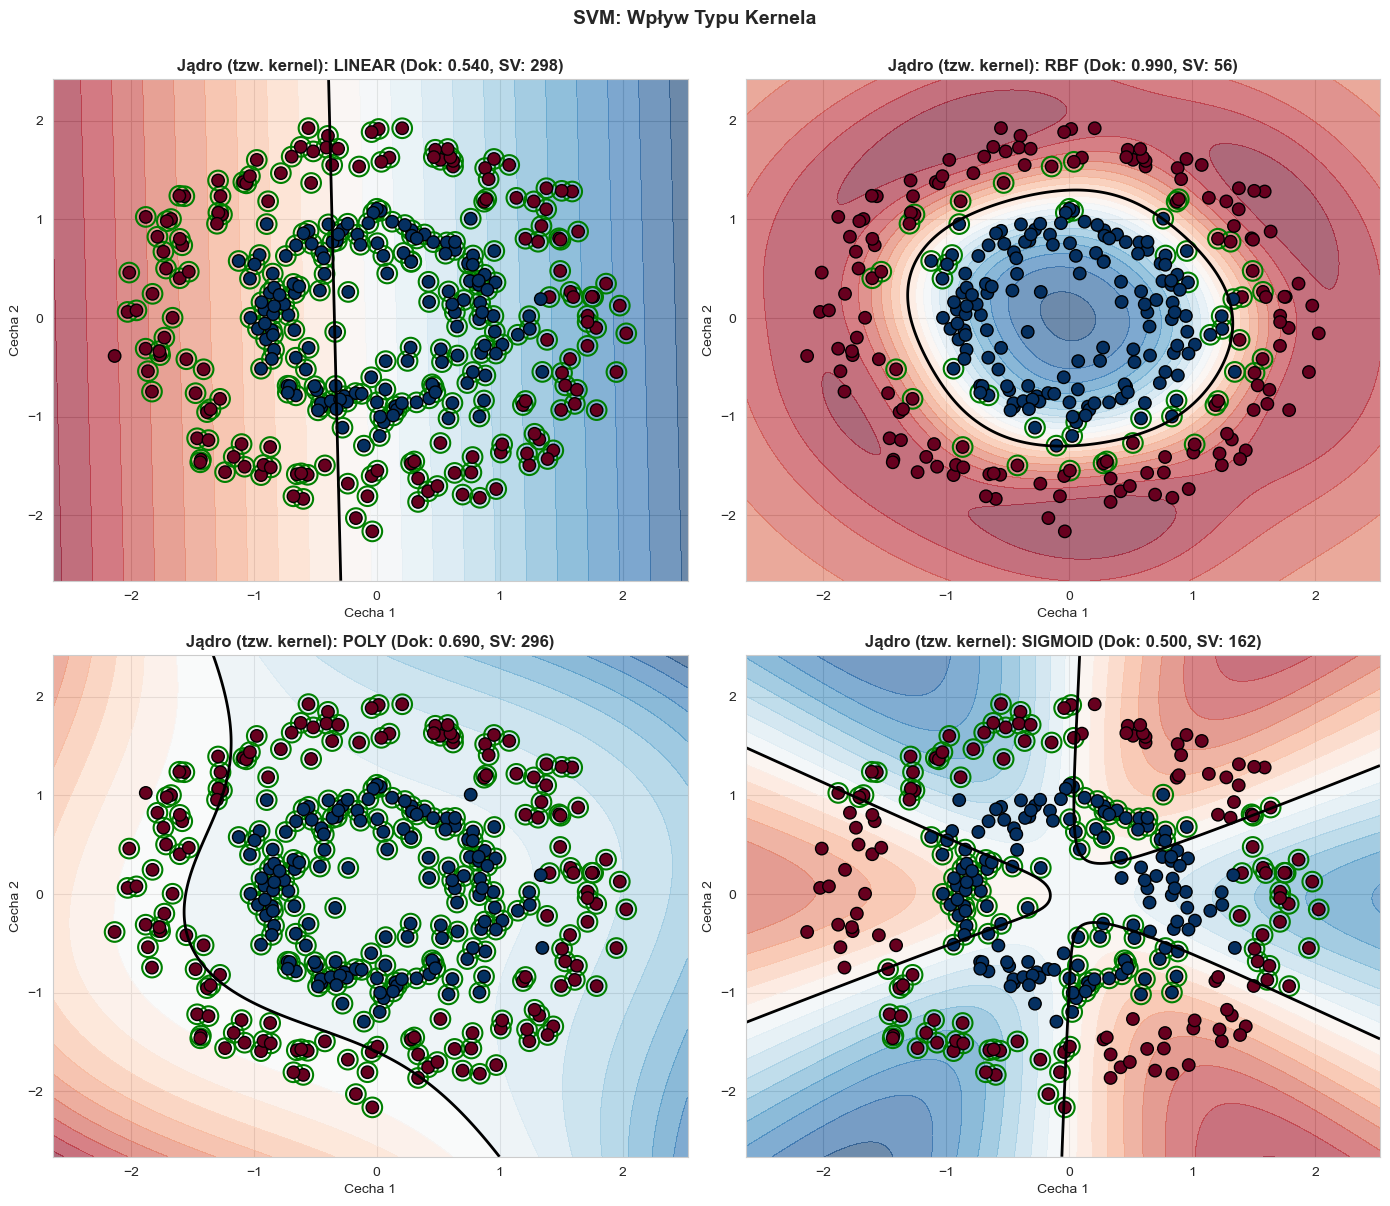

 Obserwacje:
- Liniowy: Nie radzi sobie z danymi nieliniowymi
- RBF: Doskonale dopasowuje (uważaj na przeuczenie!)
- Wielomianowy: Średnia wydajność - należałoby dostroić stopień


In [23]:
# Dane półksiężyców - nleliniowo separowalne
X_svm, y_svm = make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)

# Normalizacja
scaler_svm = StandardScaler()
X_svm_scaled = scaler_svm.fit_transform(X_svm)

# Wizualizacja jąder
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for idx, kernel_type in enumerate(kernels):
    ax = axes[idx // 2, idx % 2]
    
    svm = SVC(kernel=kernel_type, gamma=1, C=1, random_state=42)
    svm.fit(X_svm_scaled, y_svm)
    
    # Siatka
    h = 0.02
    x_min = X_svm_scaled[:, 0].min() - 0.5
    x_max = X_svm_scaled[:, 0].max() + 0.5
    y_min = X_svm_scaled[:, 1].min() - 0.5
    y_max = X_svm_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=20, cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    
    # Wektory nośne
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
              s=200, linewidth=1.5, facecolors='none', edgecolors='green')
    
    ax.scatter(X_svm_scaled[:, 0], X_svm_scaled[:, 1], c=y_svm,
              cmap=plt.cm.RdBu, edgecolors='k', s=80)
    
    acc = svm.score(X_svm_scaled, y_svm)
    n_sv = len(svm.support_)
    
    ax.set_title(f'Jądro (tzw. kernel): {kernel_type.upper()} (Dok: {acc:.3f}, SV: {n_sv})',
                fontweight='bold')
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')

plt.suptitle('SVM: Wpływ Typu Kernela',
             fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

print(' Obserwacje:')
print('- Liniowy: Nie radzi sobie z danymi nieliniowymi')
print('- RBF: Doskonale dopasowuje (uważaj na przeuczenie!)')
print('- Wielomianowy: Średnia wydajność - należałoby dostroić stopień')


Co się dzieje pod spodem? Wyobraź sobie, że chcemy przedstawić dane nieliniowe w przestrzeni wyższych wymiarów, gdzie staną się one liniowe. 

Na przykład, możemy przekształcić nasze dane 2D $(x_1, x_2)$ do przestrzeni 3D $(x_1, x_2, x_1^2 + x_2^2)$. W tej nowej przestrzeni, dane mogą być liniowo separowalne.

Na szczęście to jest bardzo szybkie, wystarczy użyć tzw. "kernel trick", który pozwala nam obliczać iloczyny skalarne w tej wyższej wymiarowej przestrzeni bez konieczności jawnego przekształcania danych.

Musimy dbać tylko o iloczyny skalarne między punktami danych, a jądro (kernel) robi to za nas.

<img src="kernel_trick.jpg" alt="Kernel Trick Illustration" width="1000"/>

# 6. Grid Search - znalezienie optymalne hiperparametry

### Bias-Variance Trade-off
Klasyczna wizualizacja:

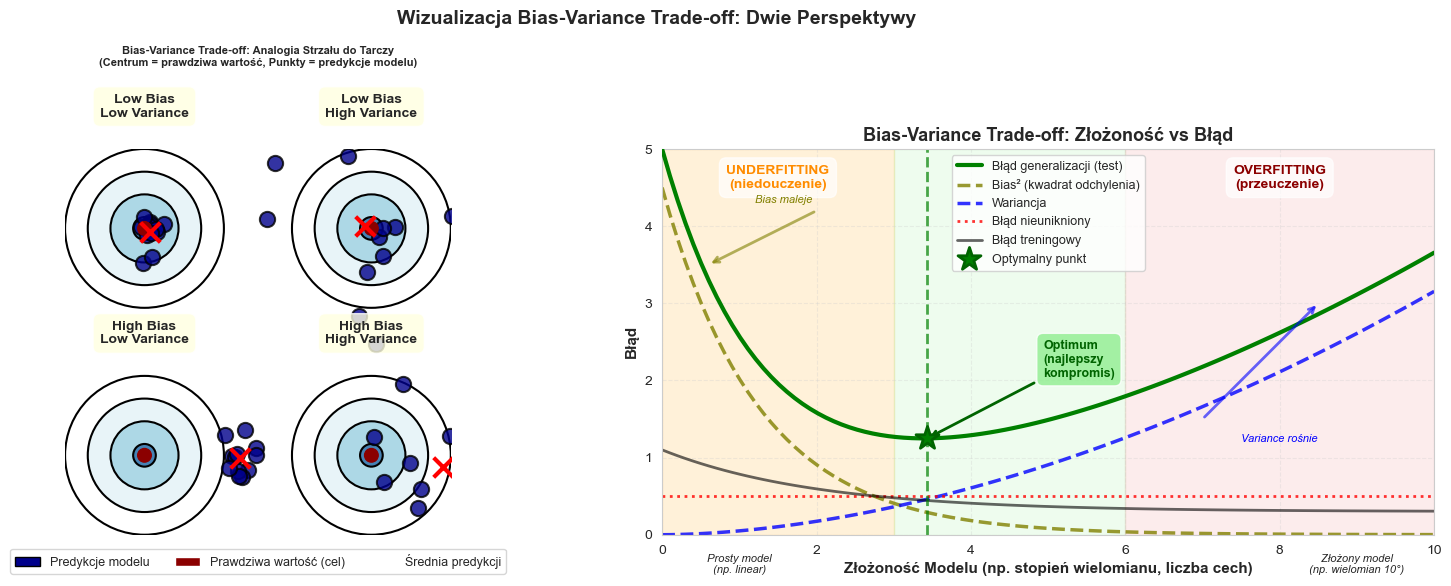

In [47]:
### KOD DLA PROWADZĄCEGO - omiń! popatrz tylko na wizualizacje ###


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===================================================================
# SUBPLOT A: Bullseye/Target Visualization
# ===================================================================

ax1 = axes[0]
scenarios = [
    {'title': 'Low Bias\nLow Variance', 'bias': 0.05, 'variance': 0.08, 'pos': (0, 1)},
    {'title': 'Low Bias\nHigh Variance', 'bias': 0.05, 'variance': 0.35, 'pos': (1, 1)},
    {'title': 'High Bias\nLow Variance', 'bias': 0.4, 'variance': 0.08, 'pos': (0, 0)},
    {'title': 'High Bias\nHigh Variance', 'bias': 0.4, 'variance': 0.35, 'pos': (1, 0)},
]

# Ustawienia dla każdej tarczy
target_radius = 0.4
center_offset_x = [0.25, 1.25]
center_offset_y = [0.25, 1.25]

for scenario in scenarios:
    col, row = scenario['pos']

    cx = center_offset_x[col]
    cy = center_offset_y[row]

    for r, color in zip([0.35, 0.25, 0.15, 0.05], ['white', '#e8f4f8', '#add8e6', '#4682b4']):
        circle = Circle((cx, cy), r, color=color, ec='black', linewidth=1.5, zorder=1)
        ax1.add_patch(circle)

    bullseye = Circle((cx, cy), 0.03, color='#8B0000', zorder=3)
    ax1.add_patch(bullseye)

    n_shots = 12
    bias_vec = np.array([scenario['bias'], 0])

    angles = np.random.uniform(0, 2*np.pi, n_shots)
    distances = np.random.normal(0, scenario['variance'], n_shots)

    shots_x = cx + bias_vec[0] + distances * np.cos(angles)
    shots_y = cy + bias_vec[1] + distances * np.sin(angles)

    ax1.scatter(shots_x, shots_y, s=120, c='darkblue', 
               edgecolors='black', linewidth=1.5, alpha=0.8, zorder=2)

    mean_x = shots_x.mean()
    mean_y = shots_y.mean()
    ax1.scatter(mean_x, mean_y, s=200, marker='x', c='red', 
               linewidth=3, zorder=4, label='Średnia' if col == 0 and row == 1 else '')

    ax1.text(cx, cy + 0.48, scenario['title'], 
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

ax1.set_xlim(-0.1, 1.6)
ax1.set_ylim(-0.1, 1.6)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('Bias-Variance Trade-off: Analogia Strzału do Tarczy\n' + 
             '(Centrum = prawdziwa wartość, Punkty = predykcje modelu)', 
             fontsize=8, fontweight='bold', pad=60)

legend_elements = [
    mpatches.Patch(facecolor='darkblue', edgecolor='black', label='Predykcje modelu'),
    mpatches.Patch(facecolor='#8B0000', label='Prawdziwa wartość (cel)'),
    plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='red', 
              markersize=10, markeredgewidth=2, label='Średnia predykcji'),
]
ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02),
          ncol=3, frameon=True, fontsize=9)

# ===================================================================
# SUBPLOT B: Model Complexity Curve
# ===================================================================

ax2 = axes[1]

complexity = np.linspace(0, 10, 100)

irreducible_error = np.ones_like(complexity) * 0.5
bias_squared = 4.5 * np.exp(-0.8 * complexity)
variance = 0.05 * complexity**1.8
training_error = 0.8 * np.exp(-0.5 * complexity) + 0.3
test_error = bias_squared + variance + irreducible_error

optimal_idx = np.argmin(test_error)
optimal_complexity = complexity[optimal_idx]

ax2.plot(complexity, test_error, 'g-', linewidth=3, label='Błąd generalizacji (test)', zorder=3)
ax2.plot(complexity, bias_squared, '--', linewidth=2.5, color='olive', 
        label='Bias² (kwadrat odchylenia)', alpha=0.8)
ax2.plot(complexity, variance, '--', linewidth=2.5, color='blue', 
        label='Wariancja', alpha=0.8)
ax2.plot(complexity, irreducible_error, ':', linewidth=2, color='red', 
        label='Błąd nieunikniony', alpha=0.8)
ax2.plot(complexity, training_error, '-', linewidth=2, color='black', 
        label='Błąd treningowy', alpha=0.6)

ax2.axvspan(0, 3, alpha=0.15, color='orange', zorder=0)
ax2.text(1.5, 4.5, 'UNDERFITTING\n(niedouczenie)', ha='center', 
        fontsize=10, fontweight='bold', color='darkorange',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

ax2.axvspan(3, 6, alpha=0.15, color='lightgreen', zorder=0)

ax2.axvspan(6, 10, alpha=0.15, color='lightcoral', zorder=0)
ax2.text(8, 4.5, 'OVERFITTING\n(przeuczenie)', ha='center', 
        fontsize=10, fontweight='bold', color='darkred',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

ax2.axvline(optimal_complexity, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax2.scatter([optimal_complexity], [test_error[optimal_idx]], 
           s=300, c='green', marker='*', edgecolors='darkgreen', 
           linewidth=2, zorder=5, label='Optymalny punkt')

ax2.annotate('Optimum\n(najlepszy\nkompromis)', 
            xy=(optimal_complexity, test_error[optimal_idx]),
            xytext=(optimal_complexity + 1.5, test_error[optimal_idx] + 0.8),
            fontsize=9, fontweight='bold', color='darkgreen',
            arrowprops=dict(arrowstyle='->', lw=2, color='darkgreen'),
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

ax2.annotate('', xy=(0.6, 3.5), xytext=(2.0, 4.2),
            arrowprops=dict(arrowstyle='->', lw=2, color='olive', alpha=0.6))
ax2.text(1.2, 4.3, 'Bias maleje', fontsize=8, color='olive', fontstyle='italic')

ax2.annotate('', xy=(8.5, 3), xytext=(7, 1.5),
            arrowprops=dict(arrowstyle='->', lw=2, color='blue', alpha=0.6))
ax2.text(7.5, 1.2, 'Variance rośnie', fontsize=8, color='blue', fontstyle='italic')

ax2.set_xlabel('Złożoność Modelu (np. stopień wielomianu, liczba cech)', 
              fontweight='bold', fontsize=11)
ax2.set_ylabel('Błąd', fontweight='bold', fontsize=11)
ax2.set_title('Bias-Variance Trade-off: Złożoność vs Błąd', 
             fontsize=13, fontweight='bold')
ax2.legend(loc='upper center', fontsize=9, frameon=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 5)

ax2.text(1, -0.5, 'Prosty model\n(np. linear)', ha='center', fontsize=8, style='italic')
ax2.text(9, -0.5, 'Złożony model\n(np. wielomian 10°)', ha='center', fontsize=8, style='italic')

plt.suptitle('Wizualizacja Bias-Variance Trade-off: Dwie Perspektywy',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Jak w praktyce zrobić grid search?


- Ustal które hiperparametry są kluczowe (bardziej istotne niż inne)
- Nie próbuj wszystkich kombinacji od samego początku (duży koszt) - zacznij od trendów
- Trzeba dostrajać tak długo, żeby nie spadła generalizacja

Na przykładzie XGBOOSTa:

**Krok 1:** Ustal `n_estimators` = 50-500 (więcej = lepiej, ale wolniej)  
**Krok 2:** Tunuj `max_depth` = 3-10 (mniej = nie underfitting, więcej = nie overfitting)  
**Krok 3:** Tunuj `learning_rate` = 0.01-0.3 (mniejszy = dokładniej, większy = szybciej)  
**Krok 4:** Tunuj `subsample` i `colsample_bytree` = 0.5-1.0 (losowość pomaga)  
**Krok 5:** Użyj `early_stopping` by zatrzymać gdy model przestaje się poprawiać 

Potencjalne problemy:
- Model się nie uczy -> LR za niski -> Zwiększ learning_rate
- Przeuczenie -> Model za złożony -> Zmniejsz max_depth lub n_estimators
- Trenowanie trwa długo -> Zbyt wiele drzew -> Zmniejsz n_estimators
- Niezmienna wydajność -> Model nie konwerguje -> Zwiększ learning_rate lub dodaj więcej drzew

**"Start Simple, Go Complex"**

1. Zacznij od domyślnych parametrów
2. Patrz na train vs test gap (przeuczenie?)
3. Zmniejsz max_depth jeśli przeuczony
4. Zwiększ n_estimators jeśli niedouczony
5. Znajdź optymalny learning_rate na koniec

# 7. Podsumowanie

## Przegląd

Dziś poznaliśmy kilka klasycznych modeli uczenia maszynowego, nie wymagających użycia sieci neuronowych (PSSS: o nich następnym razem!)

## PRZEWODNIK WYBORU ALGORYTMU:

1. K-NEAREST NEIGHBORS (KNN):
    Stosuj gdy: Małe lub średnie zbiory danych, niskowymiarowe dane
    Unikaj gdy: Duże zbiory danych, wysokowymiarowe dane
    Pamiętaj: Zawsze skaluj cechy.
    Szybko się uczą, wolna inferencja, dość łatwa wytłumaczalność, skuteczność zależy od danych, ciężko skalowalne.

2. DRZEWA DECYZYJNE:
    Stosuj gdy: Potrzebujesz interpretowalności, mieszane typy cech
    Unikaj gdy: Potrzebujesz najwyższej dokładności (lepszy ensemble)
    Pamiętaj: Podatne na przeuczenie, ogranicz m.in. max_depth!
    Szybko się uczą, bardzo szybka predykcja i wysoka wytłumaczalność, słabiej ze skutecznością.

3. LASY LOSOWE:
    Stosuj gdy: Potrzebujesz solidnej wydajności, ważności cech
    Unikaj gdy: Potrzebujesz interpretowalności, bardzo duże zbiory danych
    Świetny wybór na start!
    Poprawa skuteczności kosztem wolniejszego treningu (i inferencji).

4. MASZYNY WEKTORÓW NOŚNYCH (SVM):
    Stosuj gdy: Dane wysokowymiarowe, wyraźny margines między klasami
    Unikaj gdy: Bardzo duże zbiory (>100k próbek), potrzebujesz prawdopodobieństw
    Pamiętaj: Zawsze skaluj cechy! Trzeba stroić C i gamma!
    Dość dobra skuteczność, za to dość nieskalowalne, wolne treningi i ciężka wytłumaczalność predykcji.

5. REGRESJA LINIOWA:
    Stosuj gdy: Oczekujesz relacji liniowej, potrzebujesz interpretowalności
    Unikaj gdy: Relacje nieliniowe, złożone interakcje
    Pamiętaj: Sprawdź założenia (liniowość, homoscedastyczność)!
    Niedoceniany model, choć jeszcze wciąż często używany. Szybki trening i inferencja, dobra skalowalność choć słabiej ze skutecznością.

## OGÓLNE WSKAZÓWKI:
1. Zawsze dziel dane na zbiory treningowe/walidacyjne bądź testowe
2. Skaluj cechy dla algorytmów opartych o odległość (KNN, SVM)
3. Używaj cross-validacji dla rzetelnej oceny
4. Zacznij od prostych modeli, potem zwiększaj złożoność (Occam's razor)
5. Używaj Grid Search do strojenia hiperparametrów
6. Rozważ metody ensemble (np. Random Forest) dla solidnych wyników
7. Oceniaj wiele metryk, nie tylko dokładność (dziś na to nie było czasu...)
8. Wizualizuj granice decyzji gdy to możliwe
9. Sprawdzaj przeuczenie (wyniki na danych widzianych i niewidzianych przez model)
10. Wiedza dziedzinowa pomaga w inżynierii cech! (następny odcinek: sieci neuronowe - REWOLUCJA!)

## Inne niewspomniane klasyczne modele:
- Regresja logistyczna (lub szerzej GLM)
- Naiwny klasyfikator baysowski
- Procesy Gaussowskie
- Perceptron (rozwinięcie już za tydzień w tzw. sieciach neuronowych!)

# 8. Podziękowania / Polecajki

Polecam [wstęp do AI z MIT](https://www.youtube.com/playlist?list=PLUl4u3cNGP63gFHB6xb-kVBiQHYe_4hSi) do dobrego, intuicyjnego zrozumienia. Często też [3blue1brown](https://www.youtube.com/@3blue1brown) wrzuca fajne filmiki z intuicyjną prezentacją.

Dużo można się nauczyć (szczególnie o starym, dobrym klasycznym ML) z legendarnej książki Pattern Recognition and Machine Learning Christophera Bishopa. Inną cenioną pozycją jest Introduction to Statistical Learning (James,Witten,Hastie,Tibshirani) oraz Machine Learning: A Probabilistic Perspective Murphy'ego.

Dziękuję ... wszystkim? (na drodze mojej kariery w ML)

Część materiałów szkoleniowych została mi w spadku z kursu COMP 551 ('19) na uniwersytecie McGill w Montrealu oraz 

Część kodu została wygenerowana przy użyciu użyciu narzędzia Perplexity.